In [348]:
import descartes
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns

from arcgis.geocoding import geocode
from arcgis.gis import GIS
from dotenv import load_dotenv
from functools import reduce
from scipy.stats import zscore
from shapely.geometry import Point, Polygon
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.svm import SVC, SVR
from textwrap import wrap
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from yellowbrick.classifier import ROCAUC, ConfusionMatrix

%matplotlib inline
plt.style.use("ggplot")
sns.set_context("talk")

In [2]:
load_dotenv("")
censuskey = os.getenv("censuskey")

In [4]:
var_description = pd.DataFrame(pd.DataFrame(
    requests.get("https://api.census.gov/data/2017/acs/acs5/profile/variables.json")
                                            .json()["variables"])
                               .T.iloc[:, 3]
                               .str.title()
                               .str.replace("!!", " ", regex=True)
                               .str.replace("Percent Estimate ", " ", regex=True))
var_description.to_csv("data/var_description.csv")

In [5]:
variables = pd.DataFrame(requests.get(
    "https://api.census.gov/data/2017/acs/acs5/profile/variables.json").json()["variables"].keys(),
                         columns=["index_name"])

In [6]:
variables_selected = variables.loc[((~variables.index_name.str.contains(r'DP')|
                                     (variables.index_name.str.contains(r'DP')&
                                      variables.index_name.str.contains(r'[0-9]PE')))&
                                    ~variables.index_name.str.contains(r'PR_'))]

In [7]:
resp = requests.get(
    "https://api.census.gov/data/2017/acs/acs5/profile?get=NAME&for=county:*&in=state:*&key={}"
    .format(censuskey))

In [8]:
county = pd.DataFrame(resp.json()[1:], columns=resp.json()[0])

In [9]:
varlist = []
for var in variables_selected.index_name:
    resp = requests.get(
        "https://api.census.gov/data/2017/acs/acs5/profile?get={}&for=county:*&in=state:*&key={}"
        .format(var, censuskey))
    if resp.status_code ==200:
        varlist.append(pd.DataFrame(resp.json()[1:], columns=resp.json()[0]))

In [10]:
df_merged = reduce(lambda left, right: pd.merge(left, right, how='outer'), varlist)

In [11]:
df_merged.dropna(axis=1, inplace=True)

In [12]:
df_merged.head()

DP05_0050PE state county DP04_0016PE DP03_0048PE DP04_0029PE DP03_0022PE  \
0         0.0    01    107        9538        18.1         0.9         1.6   
1         0.0    01    119        6833        23.6         3.2         3.1   
2         0.3    01    073      306110        13.5         1.4         1.4   
3         0.0    01    023        7329        14.8         0.5         1.7   
4         0.0    01    059       14132        15.6         1.5         0.2   

  DP04_0003PE DP03_0111PE DP04_0136PE  ... DP05_0054PE DP04_0051PE  \
0        20.1        16.3        1443  ...         0.0         4.7   
1        25.8        10.3        1354  ...         0.0         8.0   
2        14.6        37.9       88248  ...         0.0        11.1   
3        25.5        24.7         783  ...         0.0         5.7   
4        18.4        30.9        2798  ...         0.0         8.1   

  DP03_0026PE DP05_0041PE DP04_0082PE DP04_0105PE DP03_0115PE GEOCOMP  \
0        6903         0.0        31.7        19.7        89.6      00   
1        4353         0.0        32.5        19.1        70.6      00   
2      300739         0.0        23.1        30.7        83.7      00   
3        4301         0.0        29.0        26.1        82.9      00   
4       12534         0.0        36.0        23.8        76.0      00   

  DP03_0039PE DP04_0095PE  
0         0.8        47.3  
1         1.1        56.6  
2         2.3        27.0  
3         1.6        49.8  
4         2.7        59.2  

[5 rows x 375 columns]

In [13]:
df_clean = pd.concat([df_merged.loc[:, ~df_merged.columns.str.contains(r'[0-9]PE')].
                    drop(columns=["STATE", "COUNTY"]),
                    df_merged.loc[:, df_merged.columns.str.contains(r'[0-9]PE')]
                    .loc[:, ((df_merged.loc[:, df_merged.columns.str.contains(r'[0-9]PE')].max()<100)&
                             (df_merged.loc[:, df_merged.columns.str.contains(r'[0-9]PE')].min()>=0))]],
                     axis=1
                   )

In [16]:
df_clean.head()

NAME state county          GEO_ID GEOCOMP DP05_0050PE  \
0    Pickens County, Alabama    01    107  0500000US01107      00         0.0   
1     Sumter County, Alabama    01    119  0500000US01119      00         0.0   
2  Jefferson County, Alabama    01    073  0500000US01073      00         0.3   
3    Choctaw County, Alabama    01    023  0500000US01023      00         0.0   
4   Franklin County, Alabama    01    059  0500000US01059      00         0.0   

  DP03_0048PE DP04_0029PE DP03_0022PE DP04_0003PE  ... DP04_0140PE  \
0        18.1         0.9         1.6        20.1  ...        12.8   
1        23.6         3.2         3.1        25.8  ...         4.9   
2        13.5         1.4         1.4        14.6  ...        11.4   
3        14.8         0.5         1.7        25.5  ...         9.3   
4        15.6         1.5         0.2        18.4  ...         9.1   

  DP05_0010PE DP04_0118PE DP05_0054PE DP04_0051PE DP05_0041PE DP04_0082PE  \
0        12.6        43.9         0.0         4.7         0.0        31.7   
1        11.3        38.4         0.0         8.0         0.0        32.5   
2        14.4        47.6         0.0        11.1         0.0        23.1   
3         9.9        38.4         0.0         5.7         0.0        29.0   
4        12.1        43.1         0.0         8.1         0.0        36.0   

  DP04_0105PE DP03_0115PE DP03_0039PE  
0        19.7        89.6         0.8  
1        19.1        70.6         1.1  
2        30.7        83.7         2.3  
3        26.1        82.9         1.6  
4        23.8        76.0         2.7  

[5 rows x 265 columns]

In [15]:
df_clean = pd.merge(county, df_clean, on = ["state", "county"])

In [17]:
df_clean.county = df_clean.NAME.str.split(',', expand=True).loc[:, 0]
df_clean.state = df_clean.NAME.str.split(',', expand=True).loc[:, 1].map(
    lambda x: x.lstrip(" "))
df_clean["FIPS5"] = df_clean.GEO_ID.apply(lambda x: int(str(x)[-5:]))
df_clean.head()

NAME    state            county          GEO_ID  \
0    Pickens County, Alabama  Alabama    Pickens County  0500000US01107   
1     Sumter County, Alabama  Alabama     Sumter County  0500000US01119   
2  Jefferson County, Alabama  Alabama  Jefferson County  0500000US01073   
3    Choctaw County, Alabama  Alabama    Choctaw County  0500000US01023   
4   Franklin County, Alabama  Alabama   Franklin County  0500000US01059   

  GEOCOMP DP05_0050PE DP03_0048PE DP04_0029PE DP03_0022PE DP04_0003PE  ...  \
0      00         0.0        18.1         0.9         1.6        20.1  ...   
1      00         0.0        23.6         3.2         3.1        25.8  ...   
2      00         0.3        13.5         1.4         1.4        14.6  ...   
3      00         0.0        14.8         0.5         1.7        25.5  ...   
4      00         0.0        15.6         1.5         0.2        18.4  ...   

  DP05_0010PE DP04_0118PE DP05_0054PE DP04_0051PE DP05_0041PE DP04_0082PE  \
0        12.6        43.9         0.0         4.7         0.0        31.7   
1        11.3        38.4         0.0         8.0         0.0        32.5   
2        14.4        47.6         0.0        11.1         0.0        23.1   
3         9.9        38.4         0.0         5.7         0.0        29.0   
4        12.1        43.1         0.0         8.1         0.0        36.0   

  DP04_0105PE DP03_0115PE DP03_0039PE FIPS5  
0        19.7        89.6         0.8  1107  
1        19.1        70.6         1.1  1119  
2        30.7        83.7         2.3  1073  
3        26.1        82.9         1.6  1023  
4        23.8        76.0         2.7  1059  

[5 rows x 266 columns]

In [21]:
election = pd.read_csv("data/countypres_2000-2016.csv")

In [22]:
election.dropna(inplace=True)

In [23]:
election["candidateshare"] = election.candidatevotes / election.totalvotes
hillary = election.loc[((election.year==2016)&(election.candidate=="Hillary Clinton"))]
hillary = hillary[["state", "county", "candidateshare", "FIPS"]]
hillary.rename(columns={"candidateshare":"hillary"}, inplace=True)
trump = election.loc[((election.year==2016)&(election.candidate=="Donald Trump"))]
trump = trump[["state", "county", "candidateshare", "FIPS"]]
trump.rename(columns={"candidateshare":"trump"}, inplace=True)

In [24]:
election_result = pd.merge(hillary, trump, on=["state", "county", "FIPS"])

In [25]:
election_result["target"] = (election_result.trump > election_result.hillary)*1
election_result.FIPS = election_result.FIPS.astype(int)
election_result.head()

state   county   hillary  FIPS     trump  target
0  Alabama  Autauga  0.237697  1001  0.727666       1
1  Alabama  Baldwin  0.193856  1003  0.765457       1
2  Alabama  Barbour  0.465278  1005  0.520967       1
3  Alabama     Bibb  0.212496  1007  0.764032       1
4  Alabama   Blount  0.084258  1009  0.893348       1

In [26]:
election_result.describe()

hillary          FIPS        trump       target
count  3153.000000   3153.000000  3153.000000  3153.000000
mean      0.316270  30299.052331     0.630576     0.840469
std       0.152591  15211.976727     0.157801     0.366228
min       0.031447   1001.000000     0.040875     0.000000
25%       0.203935  18163.000000     0.541485     1.000000
50%       0.284064  29167.000000     0.662323     1.000000
75%       0.401236  45075.000000     0.747975     1.000000
max       0.908638  56045.000000     0.960334     1.000000

In [31]:
df = pd.merge(df_clean, 
              election_result.drop(columns=["state", "county"]), 
              left_on="FIPS5",
              right_on="FIPS",
              how="inner").apply(pd.to_numeric, errors="ignore")
df.drop(columns=["FIPS5"], inplace=True)
df.rename(columns={"FIPS_x":"FIPS"}, inplace=True)
df.head()

NAME    state            county          GEO_ID  \
0    Pickens County, Alabama  Alabama    Pickens County  0500000US01107   
1     Sumter County, Alabama  Alabama     Sumter County  0500000US01119   
2  Jefferson County, Alabama  Alabama  Jefferson County  0500000US01073   
3    Choctaw County, Alabama  Alabama    Choctaw County  0500000US01023   
4   Franklin County, Alabama  Alabama   Franklin County  0500000US01059   

   GEOCOMP  DP05_0050PE  DP03_0048PE  DP04_0029PE  DP03_0022PE  DP04_0003PE  \
0        0          0.0         18.1          0.9          1.6         20.1   
1        0          0.0         23.6          3.2          3.1         25.8   
2        0          0.3         13.5          1.4          1.4         14.6   
3        0          0.0         14.8          0.5          1.7         25.5   
4        0          0.0         15.6          1.5          0.2         18.4   

   ...  DP04_0051PE  DP05_0041PE  DP04_0082PE  DP04_0105PE  DP03_0115PE  \
0  ...          4.7          0.0         31.7         19.7         89.6   
1  ...          8.0          0.0         32.5         19.1         70.6   
2  ...         11.1          0.0         23.1         30.7         83.7   
3  ...          5.7          0.0         29.0         26.1         82.9   
4  ...          8.1          0.0         36.0         23.8         76.0   

   DP03_0039PE   hillary  FIPS     trump  target  
0          0.8  0.416265  1107  0.571788       1  
1          1.1  0.740290  1119  0.246607       0  
2          2.3  0.515706  1073  0.443037       0  
3          1.6  0.426358  1023  0.563083       1  
4          2.7  0.182475  1059  0.786213       1  

[5 rows x 269 columns]

In [32]:
df.to_csv("data/election_census_final.csv")

In [526]:
X = df.iloc[:, 3:-4]
y = df.target

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [88]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.iloc[:, 2:])
X_test_scaled = scaler.transform(X_test.iloc[:, 2:])

In [89]:
rfc = RandomForestClassifier(class_weight="balanced")
rfc.fit(X_train_scaled, y_train)
print("train: ", rfc.score(X_train_scaled, y_train))
print("test: ", rfc.score(X_test_scaled, y_test))

train:  0.9961423060437206
test:  0.9267352185089974


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [90]:
rfc_features = pd.merge(pd.DataFrame(rfc.feature_importances_, 
                                     index=X.iloc[:, 2:].columns, 
                                     columns=["importance"]
                                    ).sort_values(by="importance", ascending=False),
                        var_description, 
                        how="left",
                        right_index=True, 
                        left_index=True)

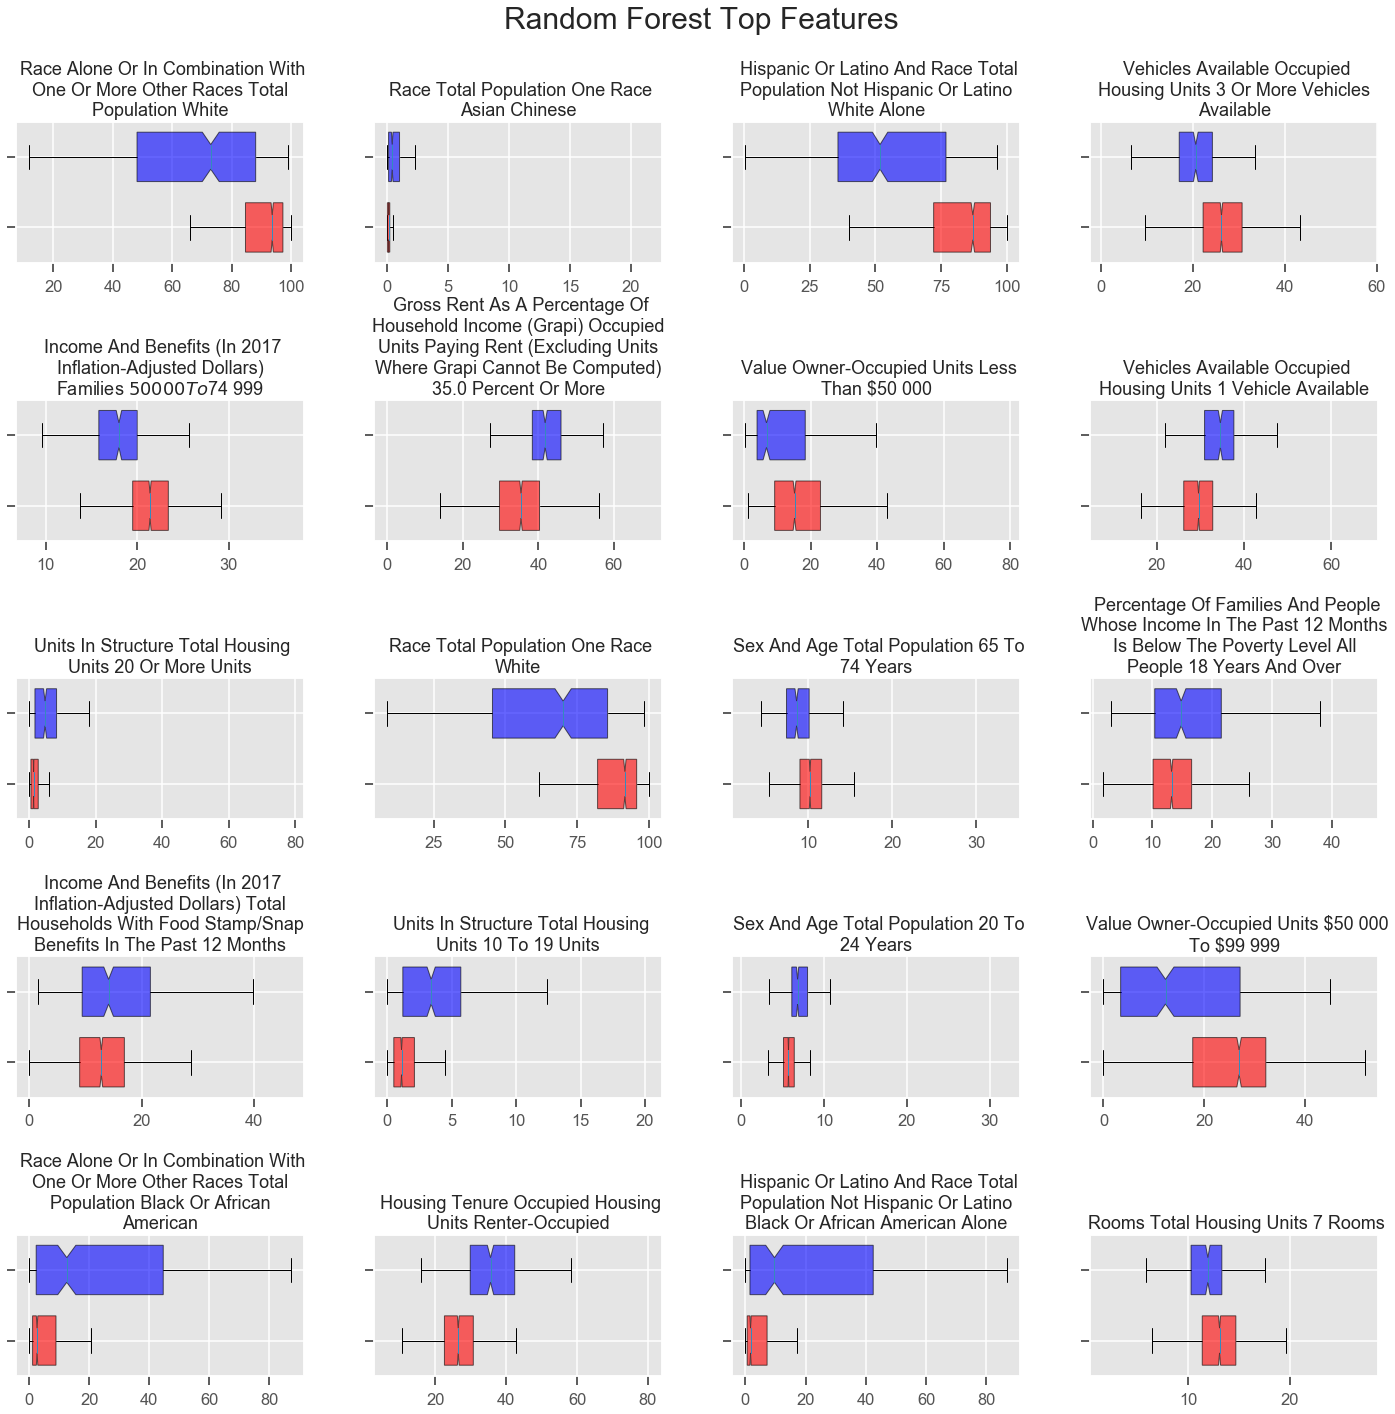

In [91]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
fig.suptitle("Random Forest Top Features", fontsize=30)
for i in range(20):
    bp = ax[i//4, i%4].boxplot([X.loc[y==1, rfc_features.index[i]], X.loc[y==0, rfc_features.index[i]]],
                               vert=False,
                               labels=["T", "H"],
                               notch=True, 
                               patch_artist=True,
                               widths=0.7
                              )
    for patch, color in zip(bp['boxes'], ["red", "blue"]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

#     ax[i//4, i%4].set_xticklabels([])
    ax[i//4, i%4].set_yticklabels([])
    ax[i//4, i%4].set_title("\n".join(wrap(rfc_features.label[i], 35)),
                            fontsize=18
                           )
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig("images/rfc_features_box")
plt.show()

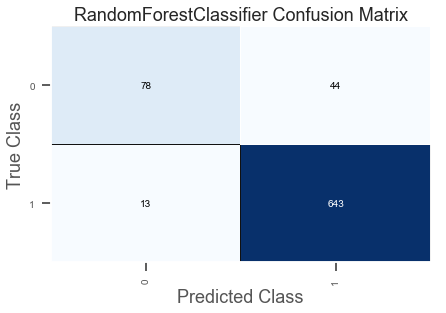

In [92]:
cm = ConfusionMatrix(rfc, 
                     classes=[0, 1],
#                      label_encoder={0: "Hillary", 1: "Trump"},
                     cmap="Blues"
                    )

cm.score(X_test_scaled, y_test)
plt.tight_layout()
cm.poof(outpath="images/cm_rfc")

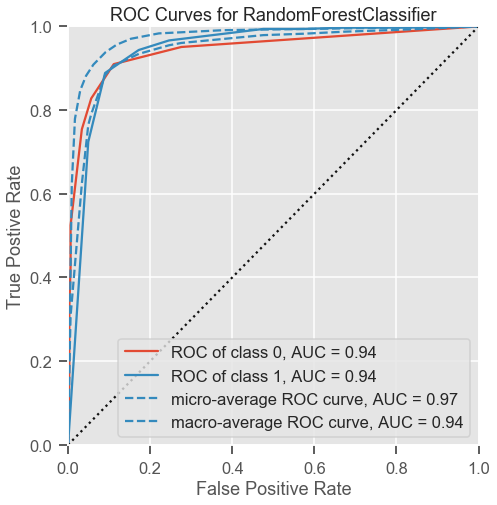

In [93]:
visualizer = ROCAUC(rfc, 
                    classes=[0, 1],
                    size=(480, 480)
                   )

visualizer.score(X_test_scaled, y_test) 
plt.tight_layout()
g = visualizer.poof(outpath="images/ROC_rfc")

In [94]:
svc = SVC(probability=True, kernel="linear")
svc.fit(X_train_scaled, y_train)
print("train: ", svc.score(X_train_scaled, y_train))
print("test: ", svc.score(X_test_scaled, y_test))

train:  0.9811401628804115
test:  0.922879177377892


In [95]:
svc_features = pd.merge(pd.DataFrame(svc.coef_.T, 
             index=X.iloc[:, 2:].columns, 
             columns=["importance"]
            ).apply(lambda x: np.abs(x)).
                        sort_values(by="importance", ascending=False),
                        var_description, 
                        how="left",
                        right_index=True, left_index=True)

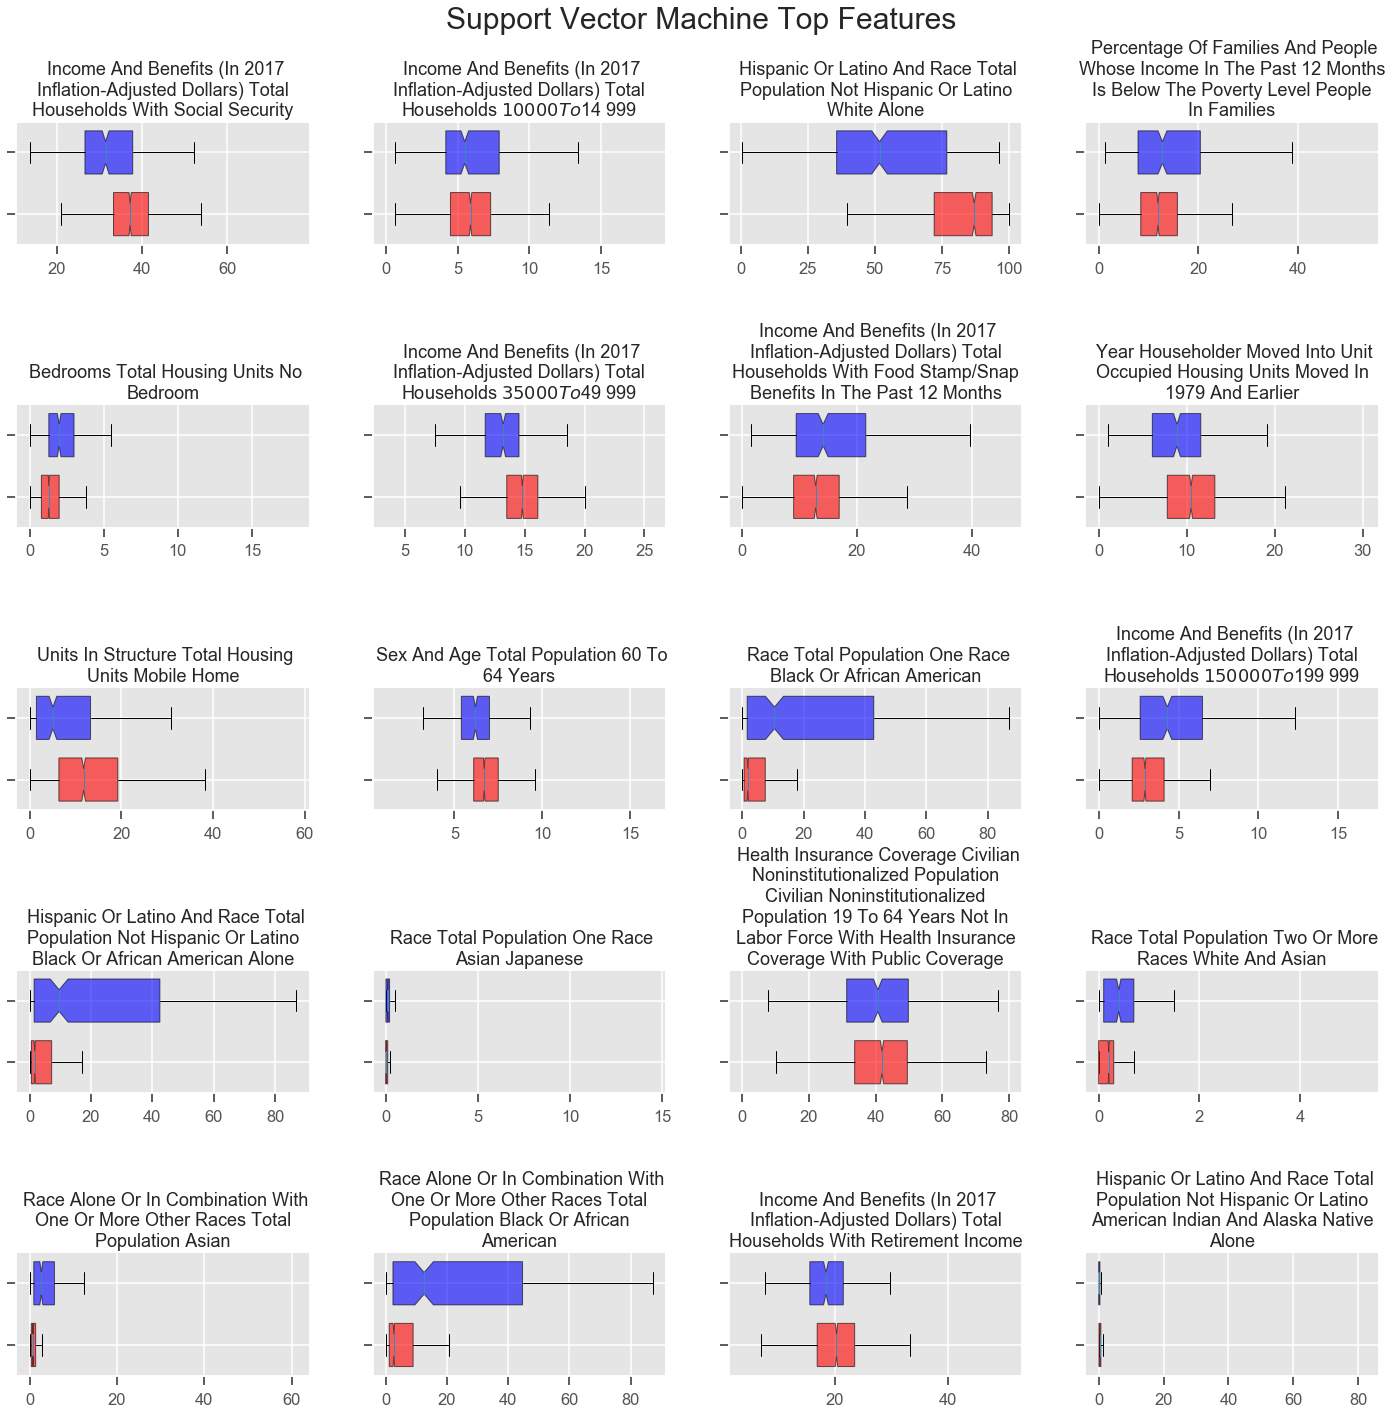

In [96]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
fig.suptitle("Support Vector Machine Top Features", fontsize=30)
for i in range(20):
    bp = ax[i//4, i%4].boxplot([X.loc[y==1, svc_features.index[i]], X.loc[y==0, svc_features.index[i]]],
                               vert=False,
                               labels=["T", "H"],
                               notch=True, 
                               patch_artist=True,
                               widths=0.7
                              )
    for patch, color in zip(bp['boxes'], ["red", "blue"]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

#     ax[i//4, i%4].set_xticklabels([])
    ax[i//4, i%4].set_yticklabels([])
    ax[i//4, i%4].set_title("\n".join(wrap(svc_features.label[i], 35)),
                            fontsize=18
                           )
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig("images/svc_features_box")
plt.show()

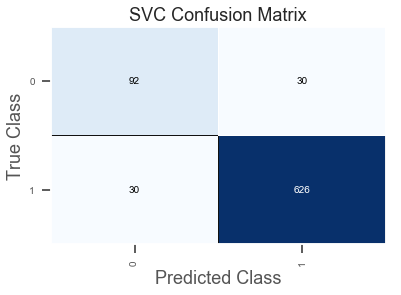

In [97]:
cm = ConfusionMatrix(svc, 
                     classes=[0, 1],
#                      label_encoder={0: "Hillary", 1: "Trump"},
                     cmap="Blues"
                    )

cm.score(X_test_scaled, y_test)
cm.poof(outpath="images/cm_svc")

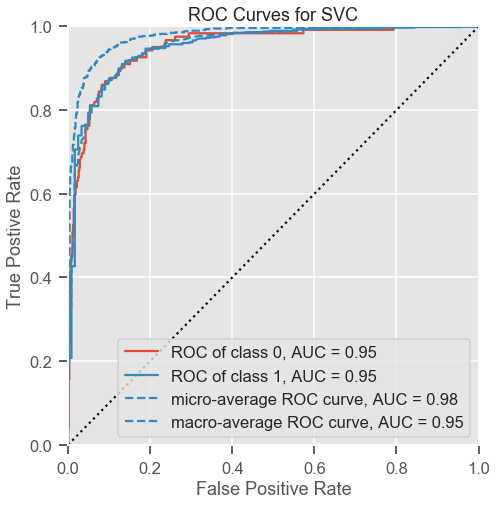

In [98]:
visualizer = ROCAUC(svc, 
                    classes=[0, 1],
                    size=(480,480)
                   )

visualizer.score(X_test_scaled, y_test) 
plt.tight_layout()
g = visualizer.poof(outpath="images/ROC_svc")

In [99]:
xgc = XGBClassifier()
xgc.fit(X_train_scaled, y_train)
print("train: ", xgc.score(X_train_scaled, y_train))
print("test: ", xgc.score(X_test_scaled, y_test))

train:  0.9918559794256322
test:  0.9550128534704371


In [100]:
xgc_features = pd.merge(pd.DataFrame(xgc.feature_importances_, 
             index=X.iloc[:, 2:].columns, 
             columns=["importance"]
            ).sort_values(by="importance", ascending=False), var_description, how="left",
                        right_index=True, left_index=True)

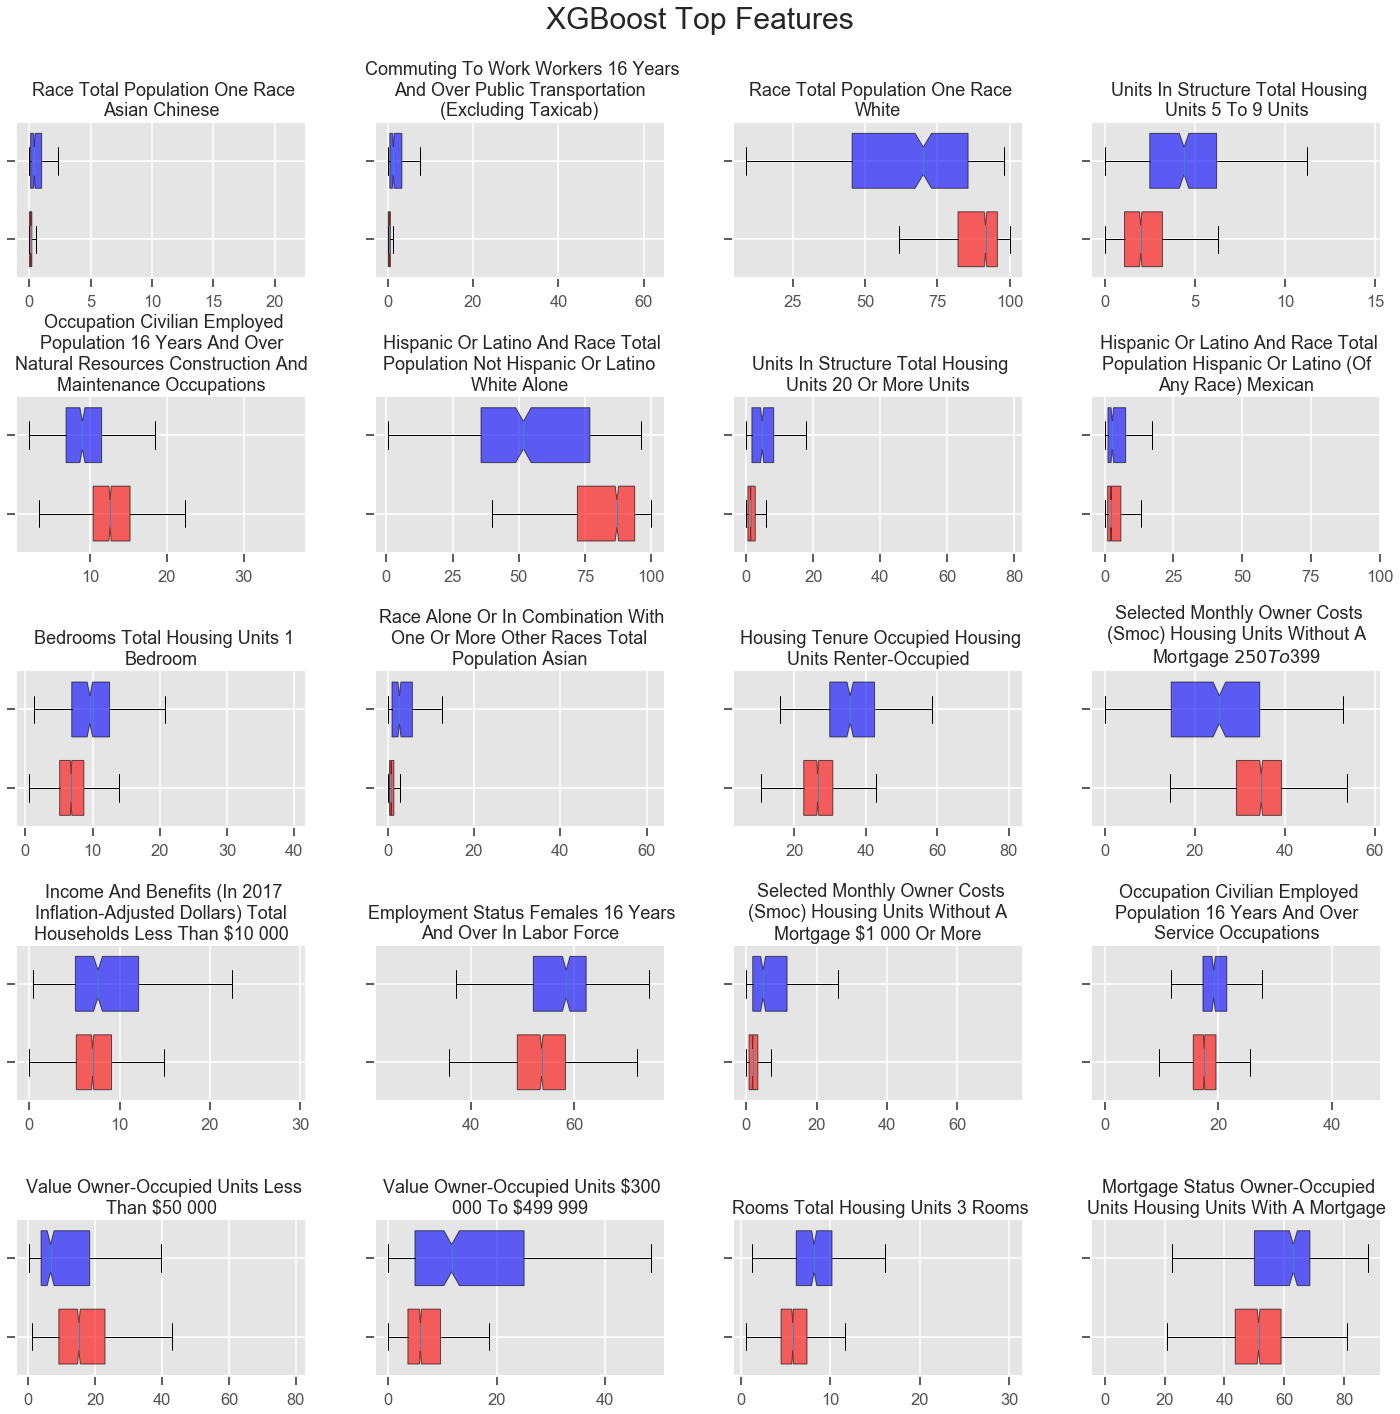

In [101]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
fig.suptitle("XGBoost Top Features", fontsize=30)
for i in range(20):
    bp = ax[i//4, i%4].boxplot([X.loc[y==1, xgc_features.index[i]], X.loc[y==0, xgc_features.index[i]]],
                               vert=False,
                               labels=["T", "H"],
                               notch=True, 
                               patch_artist=True,
                               widths=0.7
                              )
    for patch, color in zip(bp['boxes'], ["red", "blue"]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

#     ax[i//4, i%4].set_xticklabels([])
    ax[i//4, i%4].set_yticklabels([])
    ax[i//4, i%4].set_title("\n".join(wrap(xgc_features.label[i], 35)),
                            fontsize=18
                           )
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig("images/xgc_features_box")
plt.show()

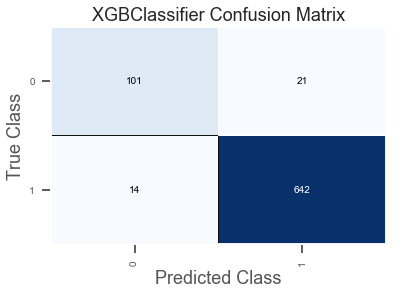

In [102]:
cm = ConfusionMatrix(xgc, 
                     classes=[0, 1],
#                      label_encoder={0: "Hillary", 1: "Trump"},
                     cmap="Blues"
                    )

cm.score(X_test_scaled, y_test)
cm.poof(outpath="images/cm_xgc")

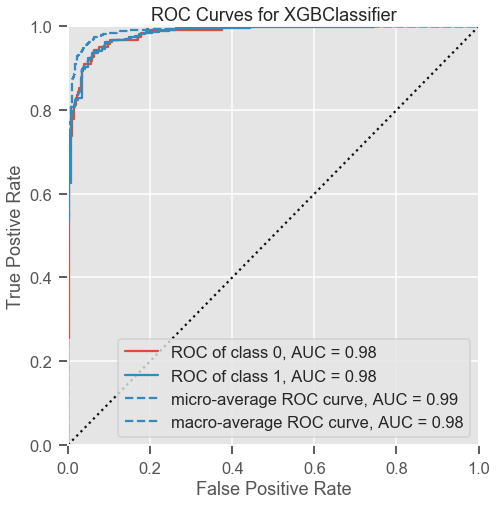

In [103]:
visualizer = ROCAUC(xgc, 
                    classes=[0, 1],
                    size=(480,480)
                   )

visualizer.score(X_test_scaled, y_test) 
plt.tight_layout()
g = visualizer.poof(outpath="images/ROC_xgc")

In [105]:
xgc_scores = {}
xgc_feature_sets = []
k=0
for i in range(0, 500, 10):
    for j in range(0, 100, 10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train.iloc[:, 2:])
        X_test_scaled = scaler.transform(X_test.iloc[:, 2:])
        xgc = XGBClassifier(reg_alpha=i, reg_lambda=j)
        xgc.fit(X_train_scaled, y_train)

        
        xgc_features = pd.merge(pd.DataFrame(xgc.feature_importances_, 
                                             index=X.iloc[:, 2:].columns,
                                             columns=["importance"]
                                            ).sort_values(by="importance", 
                                                          ascending=False), 
                                var_description, 
                                how="left",
                                right_index=True, 
                                left_index=True)
        xgc_scores[k] = [i,
                         j,
                         xgc.score(X_train_scaled, y_train),
                         xgc.score(X_test_scaled, y_test),
                         np.sum(xgc_features.importance>0)]
        xgc_feature_sets.append(xgc_features)
        k += 1

In [106]:
xgc_reg_score = pd.DataFrame(xgc_scores, 
                             index=["alpha",
                                    "lambda",
                                    "train",
                                    "test",
                                    "n_features"
                                   ]).T

In [114]:
xgc_reg_score.loc[xgc_reg_score.n_features<=10].sort_values(by="test", ascending=False).head(20)

alpha  lambda     train      test  n_features
395  390.0    50.0  0.927561  0.940874        10.0
332  330.0    20.0  0.931419  0.938303        10.0
478  470.0    80.0  0.928847  0.937018        10.0
457  450.0    70.0  0.930990  0.935733        10.0
465  460.0    50.0  0.926704  0.934447         8.0
440  440.0     0.0  0.924132  0.934447         8.0
323  320.0    30.0  0.930133  0.934447        10.0
432  430.0    20.0  0.925847  0.934447         8.0
439  430.0    90.0  0.925847  0.933162         9.0
481  480.0    10.0  0.928418  0.933162        10.0
324  320.0    40.0  0.930133  0.933162        10.0
442  440.0    20.0  0.928418  0.931877        10.0
379  370.0    90.0  0.927561  0.929306        10.0
215  210.0    50.0  0.931419  0.929306         8.0
428  420.0    80.0  0.930133  0.929306         7.0
436  430.0    60.0  0.931847  0.929306         8.0
384  380.0    40.0  0.924132  0.929306         9.0
462  460.0    20.0  0.930562  0.929306         9.0
485  480.0    50.0  0.926275  0.928021        10.0
471  470.0    10.0  0.926704  0.928021         9.0

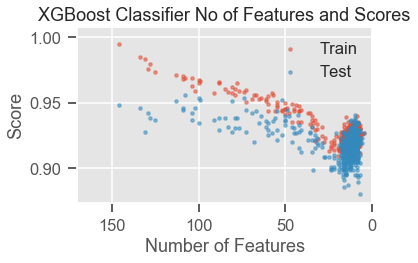

In [349]:
plt.scatter(xgc_reg_score.n_features, 
            xgc_reg_score.train,
            s=10,
            alpha=0.5
           )
plt.scatter(xgc_reg_score.n_features,
            xgc_reg_score.test,
            s=10,
            alpha=0.5
           )
plt.title("XGBoost Classifier No of Features and Scores")
plt.ylabel("Score")
plt.xlabel("Number of Features")
plt.xlim(170, 0)
plt.legend(["Train","Test"])
plt.tight_layout()
plt.savefig("images/xgc_reg_score")

In [466]:
xgc_top_feature_list = []
for i in range(30):    
    xgc_top_feature_list.append(
        xgc_feature_sets[
            xgc_reg_score.loc[xgc_reg_score.n_features<=10].sort_values(
                by="test", 
                ascending=False
            ).index[i]
        ].iloc[:10, 0]
    )

In [477]:
xgc_top_features = reduce(
    lambda left, right: pd.concat([left, right], axis=1),
    xgc_top_feature_list
).fillna(0).mean(axis=1).sort_values(ascending=False)

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


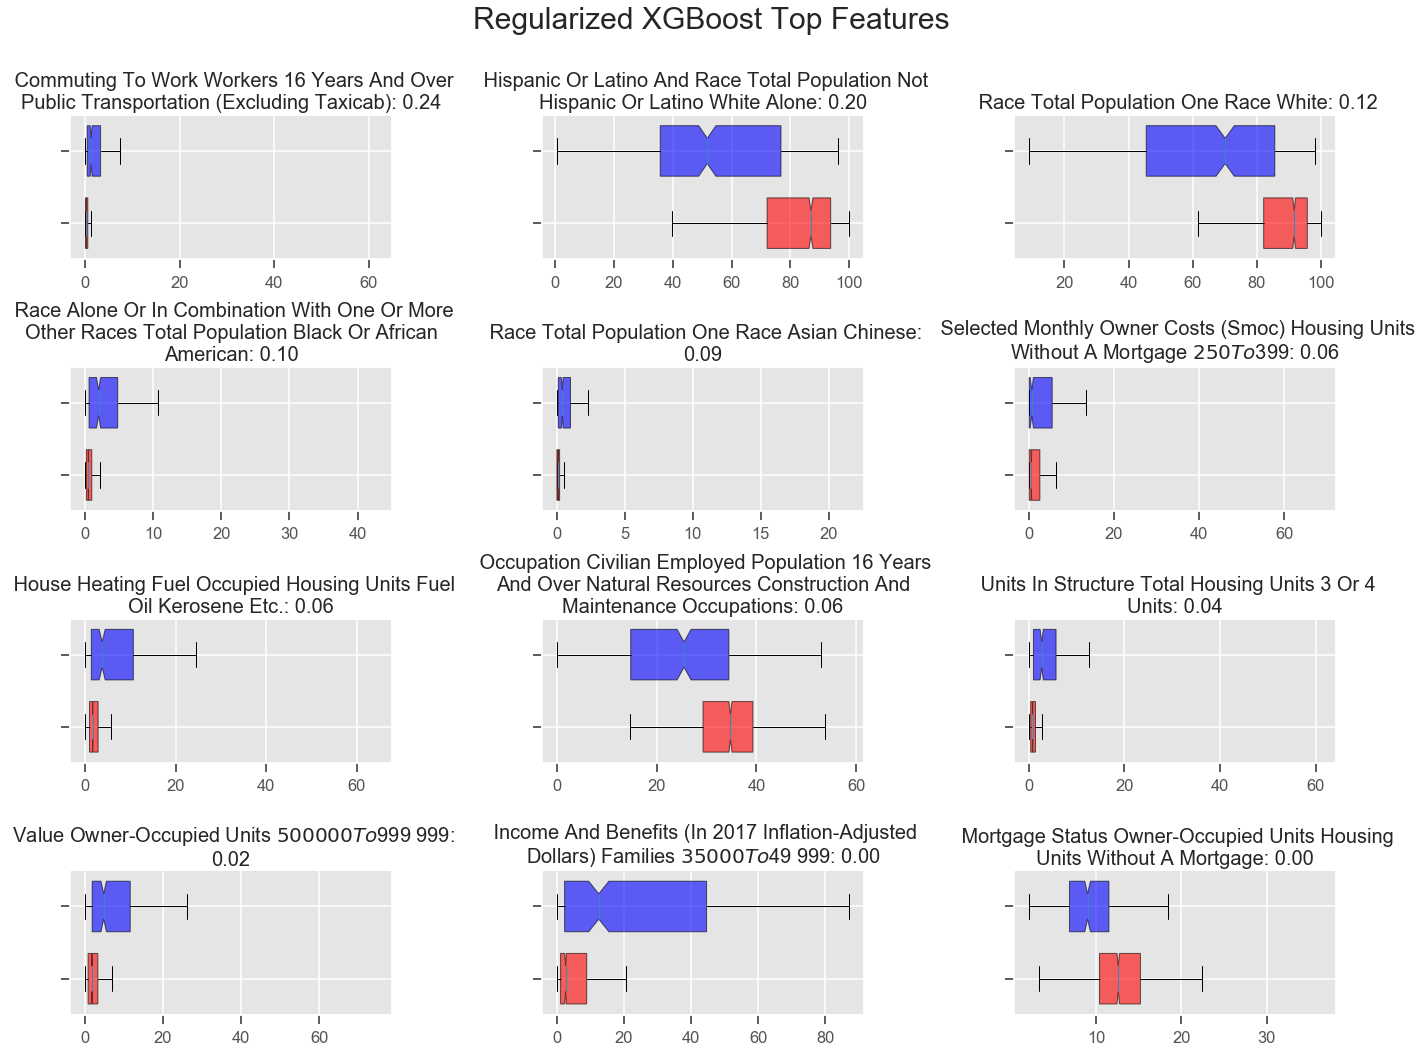

In [480]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
fig.suptitle("Regularized XGBoost Top Features", fontsize=30)
for i in range(12):
    bp = ax[i//3, i%3].boxplot([X.loc[y==1, xgc_top_features.index[i]], 
                                X.loc[y==0, xgc_top_features.index[i]]],
                               vert=False,
                               labels=["T", "H"],
                               notch=True, 
                               patch_artist=True,
                               widths=0.7
                              )
    for patch, color in zip(bp['boxes'], ["red", "blue"]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

#     ax[i//4, i%4].set_xticklabels([])
    ax[i//3, i%3].set_yticklabels([])
    ax[i//3, i%3].set_title("\n".join(
        wrap(
            xgc_feature_sets[
                xgc_reg_score.loc[
                    xgc_reg_score.n_features<=10
                ].sort_values(
                    by="test", 
                    ascending=False
                ).index[0]
            ].label[i]+": "+"{:0.2f}".format(xgc_feature_sets[
                xgc_reg_score.loc[xgc_reg_score.n_features<=10
                                 ].sort_values(by="test", 
                                               ascending=False
                                              ).index[0]
            ].importance[i]
                                            ), 
            50
        )
    ),
                            fontsize=20
                           )
    
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.savefig("images/xgc_features_reg_box")
plt.show()

In [122]:
xgc_trials = y
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.iloc[:, 2:])
    X_test_scaled = scaler.transform(X_test.iloc[:, 2:])
    xgc = XGBClassifier(verbose=False)
    xgc.fit(X_train_scaled, y_train)
    pred = pd.DataFrame(xgc.predict(X_test_scaled), index=X_test.index, columns=[i])

    xgc_trials = pd.merge(xgc_trials, pred, how="left", left_index=True, right_index=True)
    if (i+1)%100==0:
        print("progress: {}% done".format((i+1)/10))

progress: 0.0% done
progress: 10.0% done
progress: 20.0% done
progress: 30.0% done
progress: 40.0% done
progress: 50.0% done
progress: 60.0% done
progress: 70.0% done
progress: 80.0% done
progress: 90.0% done


In [134]:
xgc_trials.head()

target   0    1    2    3    4    5    6    7    8  ...  996  997  998  \
0       1 NaN  NaN  1.0  NaN  1.0  NaN  1.0  1.0  NaN  ...  NaN  NaN  NaN   
1       0 NaN  NaN  NaN  NaN  NaN  0.0  0.0  NaN  NaN  ...  NaN  NaN  0.0   
2       0 NaN  0.0  NaN  NaN  NaN  NaN  1.0  1.0  NaN  ...  NaN  NaN  0.0   
3       1 NaN  NaN  NaN  1.0  1.0  NaN  NaN  NaN  NaN  ...  1.0  NaN  NaN   
4       1 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  ...  NaN  NaN  1.0   

   999       avg      diff  FIPS     trump   hillary    margin  
0  1.0  1.000000  0.000000  1107  0.571788  0.416265  0.155523  
1  NaN  0.000000  0.000000  1119  0.246607  0.740290 -0.493683  
2  NaN  0.614841 -0.614841  1073  0.443037  0.515706 -0.072668  
3  NaN  1.000000  0.000000  1023  0.563083  0.426358  0.136725  
4  1.0  1.000000  0.000000  1059  0.786213  0.182475  0.603738  

[5 rows x 1007 columns]

In [124]:
xgc_trials["avg"] = xgc_trials.iloc[:, 1:].mean(axis=1)
xgc_trials["diff"] = xgc_trials.target - xgc_trials.avg
xgc_trials["FIPS"] = df.FIPS
xgc_trials["trump"] = df.trump
xgc_trials["hillary"] = df.hillary
xgc_trials["margin"] = xgc_trials.trump - xgc_trials.hillary
xgc_trials["state"] = df.state

In [126]:
xgc_trials["diff"].max(), xgc_trials["diff"].min()

(1.0, -1.0)

In [ ]:
df.shape

In [ ]:
xgc_trials["diff"].shape

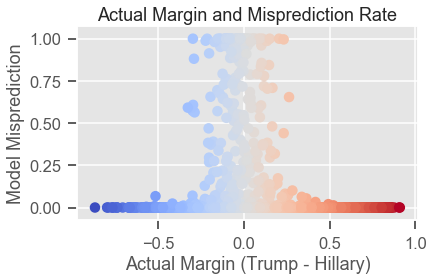

In [138]:
plt.scatter(xgc_trials.margin, 
            xgc_trials["diff"].apply(np.abs), 
            c=xgc_trials.margin, 
            cmap="coolwarm")
plt.xlabel("Actual Margin (Trump - Hillary)")
plt.ylabel("Model Misprediction")
plt.title("Actual Margin and Misprediction Rate")
plt.tight_layout()
plt.savefig("images/xgc_misprediction_margin")
plt.show()

In [137]:
swing_states = "Colorado, Florida, Iowa, Michigan, Minnesota, Ohio, Nevada, New Hampshire, North Carolina, Pennsylvania, Virginia, Wisconsin".split(", ")

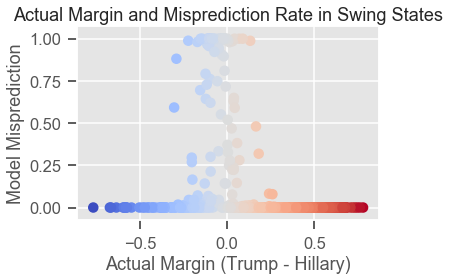

In [144]:
plt.scatter(xgc_trials.loc[(xgc_trials.state.isin(swing_states)), "margin"], 
            xgc_trials.loc[(xgc_trials.state.isin(swing_states)), "diff"].apply(np.abs), 
            c=xgc_trials.loc[(xgc_trials.state.isin(swing_states))].margin, 
            cmap="coolwarm")
plt.xlabel("Actual Margin (Trump - Hillary)")
plt.ylabel("Model Misprediction")
plt.title("Actual Margin and Misprediction Rate in Swing States")
plt.tight_layout()
plt.savefig("images/xgc_misprediction_margin_swing")
plt.show()

In [145]:
df_places = gpd.read_file('data/cbg.geojson')

In [499]:
df_places = df_places.loc[df_places.BlockGroup!="0"]
df_places["FIPS"] = df_places.CensusBlockGroup.str[:5].astype(int)

In [153]:
county["FIPS"] = (county.state + county.county).astype(int)

In [158]:
county.head()

NAME state county  FIPS
0    Pickens County, Alabama    01    107  1107
1     Sumter County, Alabama    01    119  1119
2  Jefferson County, Alabama    01    073  1073
3    Choctaw County, Alabama    01    023  1023
4   Franklin County, Alabama    01    059  1059

In [500]:
county_poly = pd.merge(county, 
                       df_places[["FIPS", "geometry"]],  
                       on="FIPS", 
                       how="left")

In [501]:
county_poly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219734 entries, 0 to 219733
Data columns (total 5 columns):
NAME        219734 non-null object
state       219734 non-null object
county      219734 non-null object
FIPS        219734 non-null int64
geometry    219734 non-null object
dtypes: int64(1), object(4)
memory usage: 10.1+ MB


In [502]:
xgc_poly = pd.merge(county_poly, xgc_trials[["FIPS", "state", "diff", "trump", "margin"]], how="left", on="FIPS")

In [503]:
xgc_poly = gpd.GeoDataFrame(xgc_poly)

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


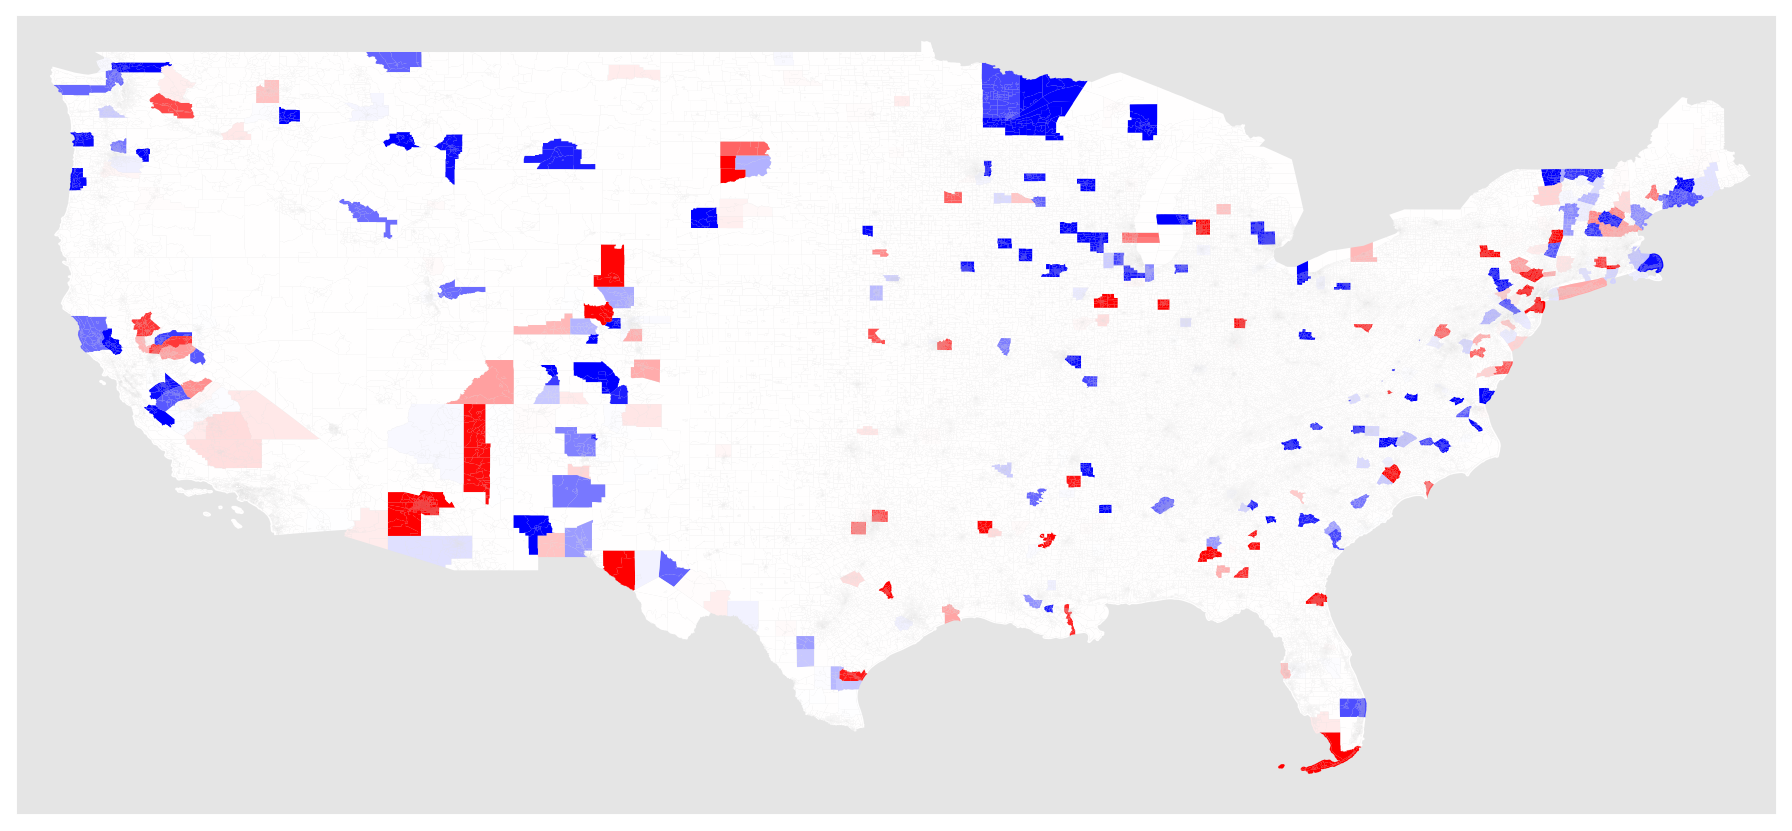

In [167]:
fig, ax = plt.subplots(1, figsize=(25, 12))
ax = xgc_poly.plot(column='diff', cmap='bwr', ax=ax)
ax.set_xlim([-126, -66])
ax.set_ylim([23, 50.25])
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout()
plt.savefig("images/xgc_diff_map")
plt.show()

In [505]:
mdv_poly = county_poly.loc[((county_poly.state=="11")|
                           (county_poly.state=="51")|
                           (county_poly.state=="24"))
                          ]

In [506]:
xgc_mdv_poly = pd.merge(mdv_poly, xgc_trials[["FIPS", "diff", "trump", "margin"]], how="left", on="FIPS")

In [507]:
xgc_mdv_poly = gpd.GeoDataFrame(xgc_mdv_poly)

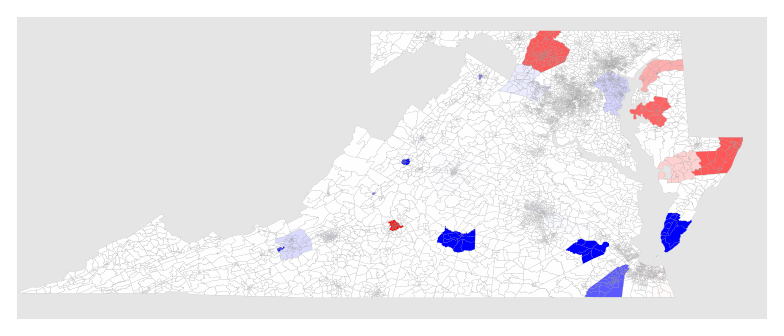

In [508]:
fig, ax = plt.subplots(1, figsize=(12, 5))
ax = xgc_mdv_poly.plot(column='diff', 
                       cmap='bwr', 
                       ax=ax,
                       linewidth=0.1, 
                       edgecolor="grey"
                      )
ax.set_xlim([-83.7, -74.75])
ax.set_ylim([36.28, 39.9])
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout()
plt.savefig("images/xgc_diff_map_dc")
plt.show()

In [509]:
xgc_poly["competitiveness"] = xgc_poly.margin.apply(lambda x: np.sign(x)*(1-np.abs(x))) * (np.abs(xgc_poly["diff"]+0.1))

In [510]:
swing_state_FIPS = county.loc[county.NAME.apply(lambda x: x.split(", ")[1]).isin(swing_states), "state"]

In [511]:
dummy_poly = xgc_poly.loc[county_poly.state=="15"].iloc[0:2]

In [512]:
dummy_poly.competitiveness = [-1, 1]

In [513]:
dummy_poly

NAME state_x county   FIPS  \
57543  Hawaii County, Hawaii      15    001  15001   
57544  Hawaii County, Hawaii      15    001  15001   

                                                geometry state_y  diff  \
57543  (POLYGON ((-155.9905299996597 19.6384599997292...  Hawaii   0.0   
57544  (POLYGON ((-155.9204300000444 19.5046100001514...  Hawaii   0.0   

          trump    margin  competitiveness  
57543  0.269798 -0.366257               -1  
57544  0.269798 -0.366257                1

In [514]:
swing_gdf_dict = {}
for state in swing_states:
    swing_gdf_dict[state] = gpd.GeoDataFrame(
        pd.concat(
            [
                pd.DataFrame(xgc_poly.loc[xgc_poly.state_y==state]),
                pd.DataFrame(dummy_poly)
            ]
        )
    )


In [194]:
gis = GIS()

In [515]:
county_swing = county.loc[county.state.isin(swing_state_FIPS)]

In [516]:
# location_df = county_swing.NAME.apply(lambda x: geocode(x)[0]['location'])
county_swing["longitude"] = location_df.apply(lambda x: x["x"])
county_swing["latitude"] = location_df.apply(lambda x: x["y"])

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [517]:
for state in county_swing.state.unique():
    county_swing.loc[
        county_swing.state==state,
        "ln_ol"
    ] = np.abs(
        zscore(
            county_swing.loc[
                county_swing.state==state, 
                "longitude"
            ]
        )
    )
    county_swing.loc[
        county_swing.state==state,
        "lt_ol"
    ] = np.abs(
        zscore(
            county_swing.loc[
                county_swing.state==state, 
                "latitude"
            ]
        )
    )

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [518]:
swing_state_range = county_swing.loc[
    ~(county_swing.ln_ol>2)&
    ~(county_swing.lt_ol>2)
].groupby("state")[
    ["longitude", 
     "latitude"
    ]
].agg(["min", "max"])

In [519]:
swing_state_range

longitude               latitude           
              min         max        min        max
state                                              
08    -108.596794 -102.351735  37.193551  40.875927
12     -87.377222  -80.383173  25.614182  30.867928
19     -96.214057  -90.539458  40.644563  43.380480
26     -87.870280  -82.680866  41.887764  46.470688
27     -96.490738  -91.782997  43.671482  48.358112
32    -119.766970 -114.877396  37.643257  41.406846
33     -72.251175  -71.030425  42.915304  43.940728
37     -83.750123  -75.819948  34.525217  36.491452
39     -84.647964  -80.748215  38.804318  41.707411
42     -80.349438  -75.033824  39.853786  41.991665
51     -82.350213  -75.382970  36.583236  39.112266
55     -92.452610  -87.317311  42.576803  46.523590

In [520]:
swing_state_range.loc["08", "longitude"]["min"] = -108.8
swing_state_range.loc["12", "latitude"]["min"] = 24.5
swing_state_range.loc["26", "longitude"]["min"] = -90
swing_state_range.loc["26", "longitude"]["max"] = -82.5
swing_state_range.loc["26", "latitude"]["max"] = 48
swing_state_range.loc["27", "longitude"]["min"] = -96.8
swing_state_range.loc["27", "longitude"]["max"] = -90
swing_state_range.loc["27", "latitude"]["max"] = 49
swing_state_range.loc["32", "longitude"]["max"] = -114.0
swing_state_range.loc["32", "latitude"]["max"] = 42
swing_state_range.loc["32", "latitude"]["min"] = 35.4
swing_state_range.loc["33", "latitude"]["max"] = 45
swing_state_range.loc["33", "latitude"]["min"] = 43
swing_state_range.loc["37", "longitude"]["min"] = -84.2
swing_state_range.loc["37", "latitude"]["min"] = 34
swing_state_range.loc["37", "latitude"]["max"] = 36.2
swing_state_range.loc["39", "latitude"]["min"] = 38.6
swing_state_range.loc["39", "latitude"]["max"] = 42
swing_state_range.loc["39", "longitude"]["min"] = -84.6
swing_state_range.loc["51", "longitude"]["min"] = -83.2
swing_state_range.loc["55", "longitude"]["max"] = -87
swing_state_range.loc["55", "latitude"]["max"] = 47

In [359]:
class MidpointNormarize(colors.Normalize):
    def __init__(self, vmin=None, vmax = None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
        
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [454]:
state = "New Hampshire"
((swing_state_range.loc
             [
                 swing_gdf_dict[state]["state_x"].unique()[0]
             ],
             swing_state_range.loc
             [
                 swing_gdf_dict[state]["state_x"].unique()[0]
             ]
 ),
             (swing_state_range.loc
             [
                 swing_gdf_dict[state]["state_x"].unique()[0]
             ]["latitude"],
             swing_state_range.loc
             [
                 swing_gdf_dict[state]["state_x"].unique()[0]
             ]["latitude"]
             )
           )

((longitude  min   -72.251175
             max   -71.030425
  latitude   min    43.000000
             max    45.000000
  Name: 33, dtype: float64, longitude  min   -72.251175
             max   -71.030425
  latitude   min    43.000000
             max    45.000000
  Name: 33, dtype: float64), (min    43.0
  max    45.0
  Name: 33, dtype: float64, min    43.0
  max    45.0
  Name: 33, dtype: float64))

In [447]:
swing_gdf_dict[state]["state_x"].unique()[0]

'33'

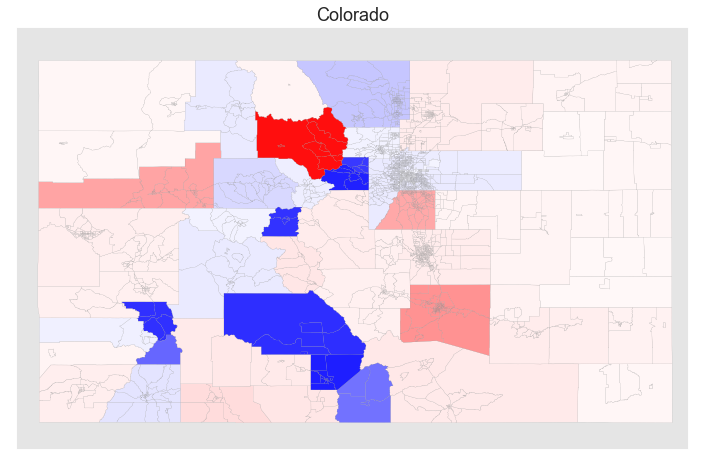

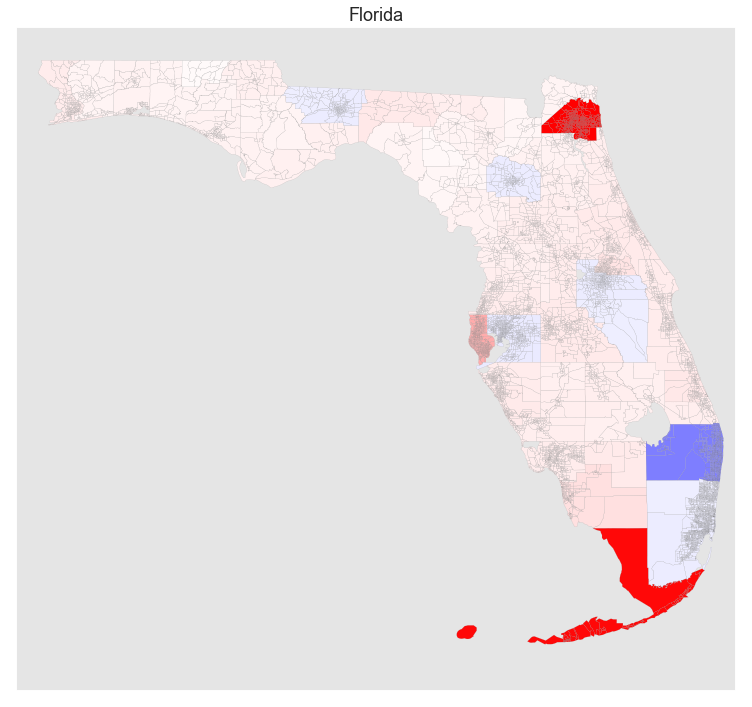

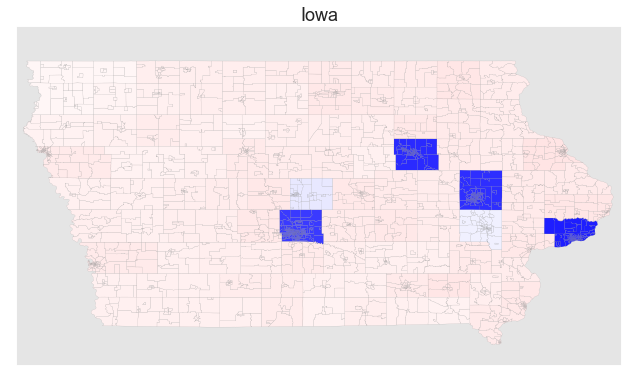

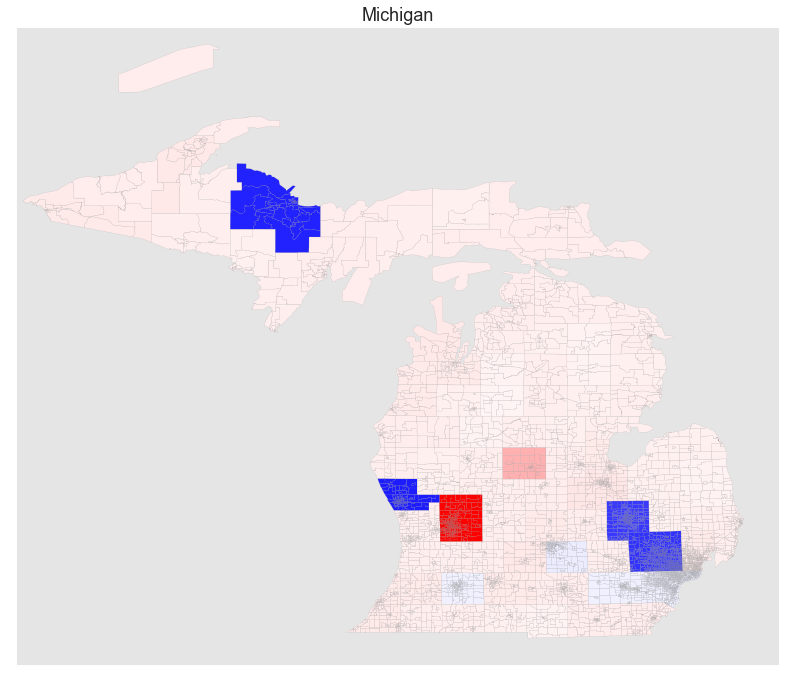

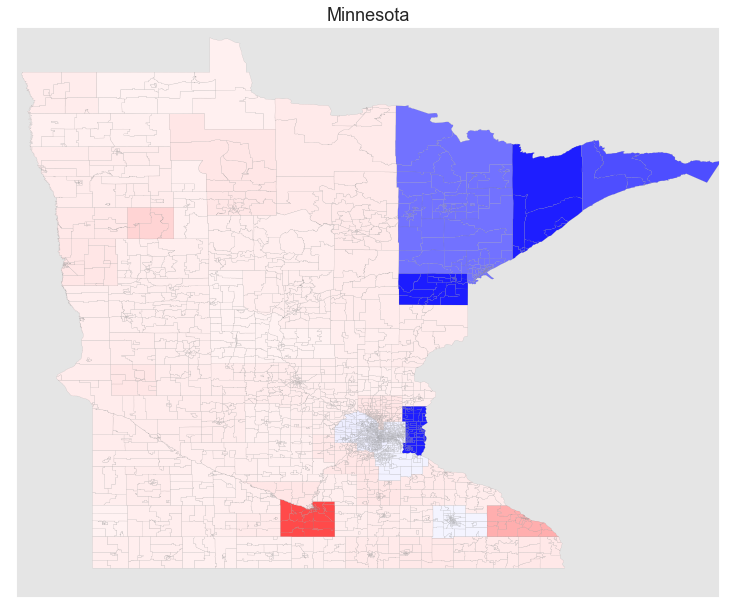

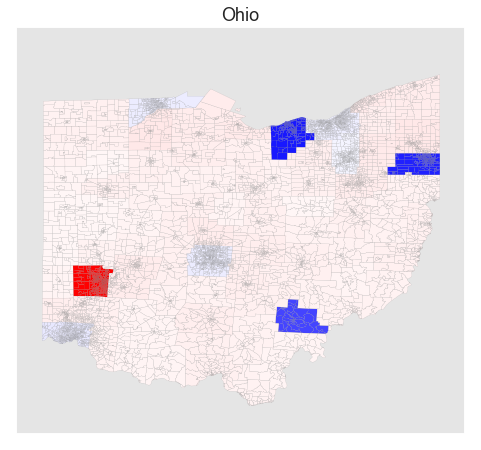

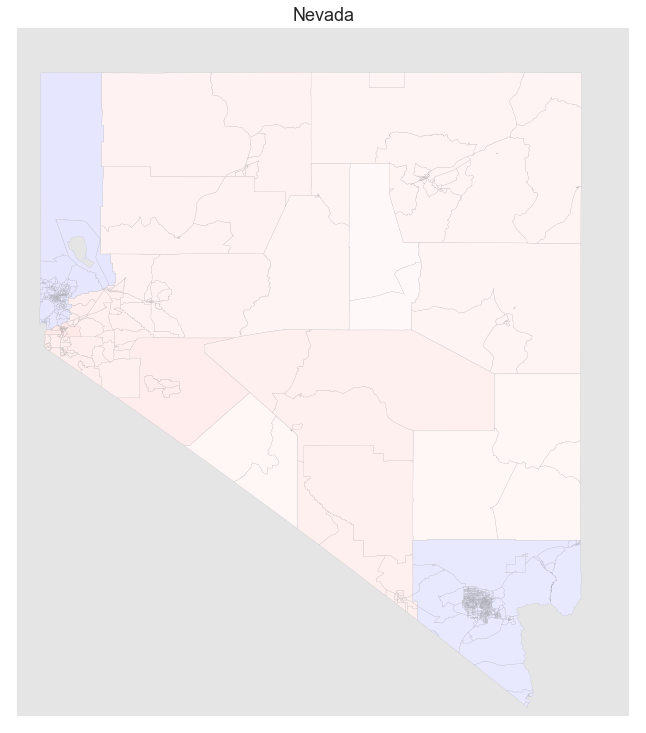

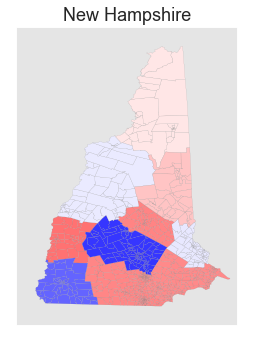

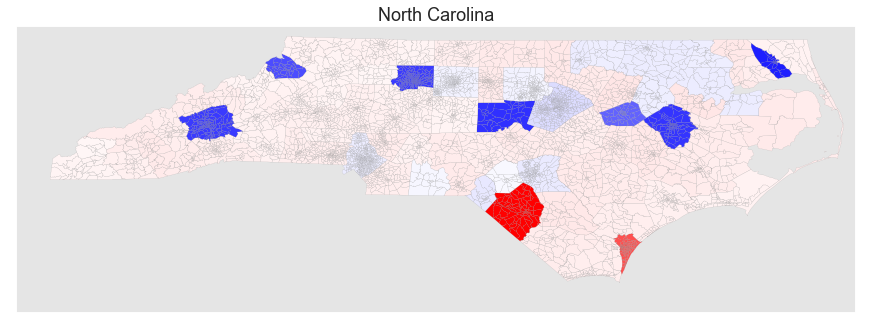

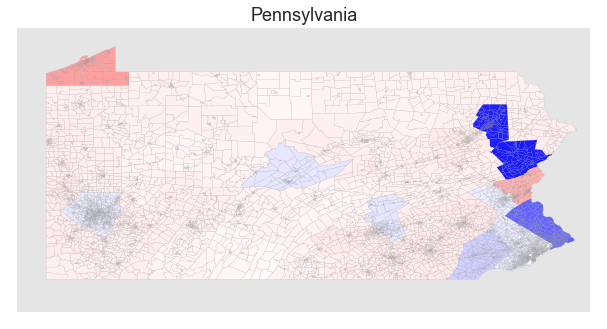

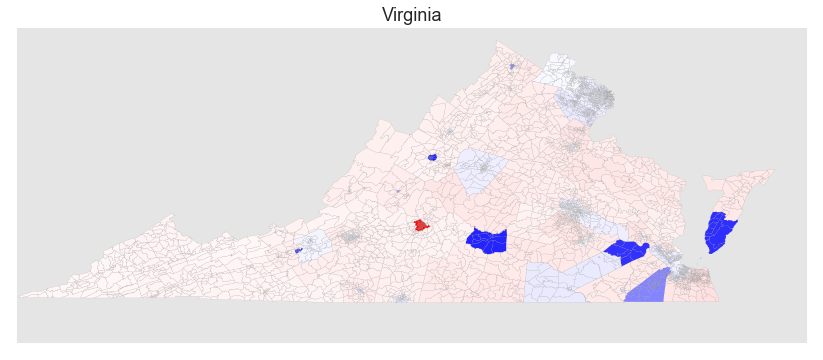

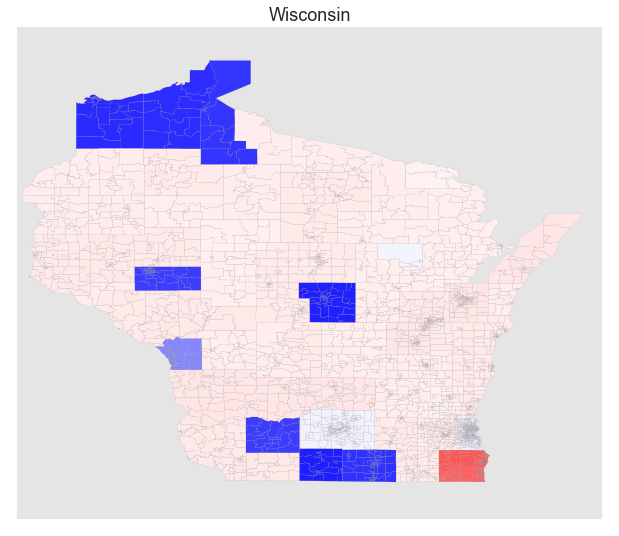

In [521]:
for state in swing_states:
    size = ((swing_state_range.loc
             [
                 swing_gdf_dict[state]["state_x"].unique()[0]
             ]["longitude"]["max"]-
             swing_state_range.loc
             [
                 swing_gdf_dict[state]["state_x"].unique()[0]
             ]["longitude"]["min"]+2
            )*1.2,
             (swing_state_range.loc
             [
                 swing_gdf_dict[state]["state_x"].unique()[0]
             ]["latitude"]["max"]-
             swing_state_range.loc
             [
                 swing_gdf_dict[state]["state_x"].unique()[0]
             ]["latitude"]["min"]+2
             )*1.2+0.8
           )
    
    fig, ax = plt.subplots(1, figsize=size)
    ax = swing_gdf_dict[state].plot(column="competitiveness", 
                                    norm=MidpointNormarize(midpoint=0.),
                                    cmap='bwr', 
                                    ax=ax,
                                    linewidth=0.1,
                                    edgecolor="grey"
                                   )
    ax.set_xlim(swing_state_range.loc[swing_gdf_dict[state]["state_x"].unique()[0]]["longitude"]["min"]-0.5,
                swing_state_range.loc[swing_gdf_dict[state]["state_x"].unique()[0]]["longitude"]["max"]+0.5)
    ax.set_ylim(swing_state_range.loc[swing_gdf_dict[state]["state_x"].unique()[0]]["latitude"]["min"]-0.5,
                swing_state_range.loc[swing_gdf_dict[state]["state_x"].unique()[0]]["latitude"]["max"]+0.5)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(state)
    plt.tight_layout()
    plt.savefig("images/xgc_competitive_map_{}".format(state))
    plt.show() 

In [528]:
X = df.iloc[:, 3:-4]
y_margin = df.trump - df.hillary

In [530]:
X_train, X_test, ym_train, ym_test = train_test_split(X, y_margin, random_state=0)

In [531]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.iloc[:, 2:])
X_test_scaled = scaler.transform(X_test.iloc[:, 2:])

In [533]:
rfr = RandomForestRegressor()
rfr.fit(X_train_scaled, ym_train)
print("train: ", rfr.score(X_train_scaled, ym_train))
print("test: ", rfr.score(X_test_scaled, ym_test))

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train:  0.9624677044419181
test:  0.8248989841471175


In [534]:
rfr_features = pd.merge(pd.DataFrame(rfr.feature_importances_, 
                                     index=X.iloc[:, 2:].columns, 
                                     columns=["importance"]
                                    ).sort_values(by="importance", ascending=False),
                        var_description, 
                        how="left",
                        right_index=True, 
                        left_index=True)

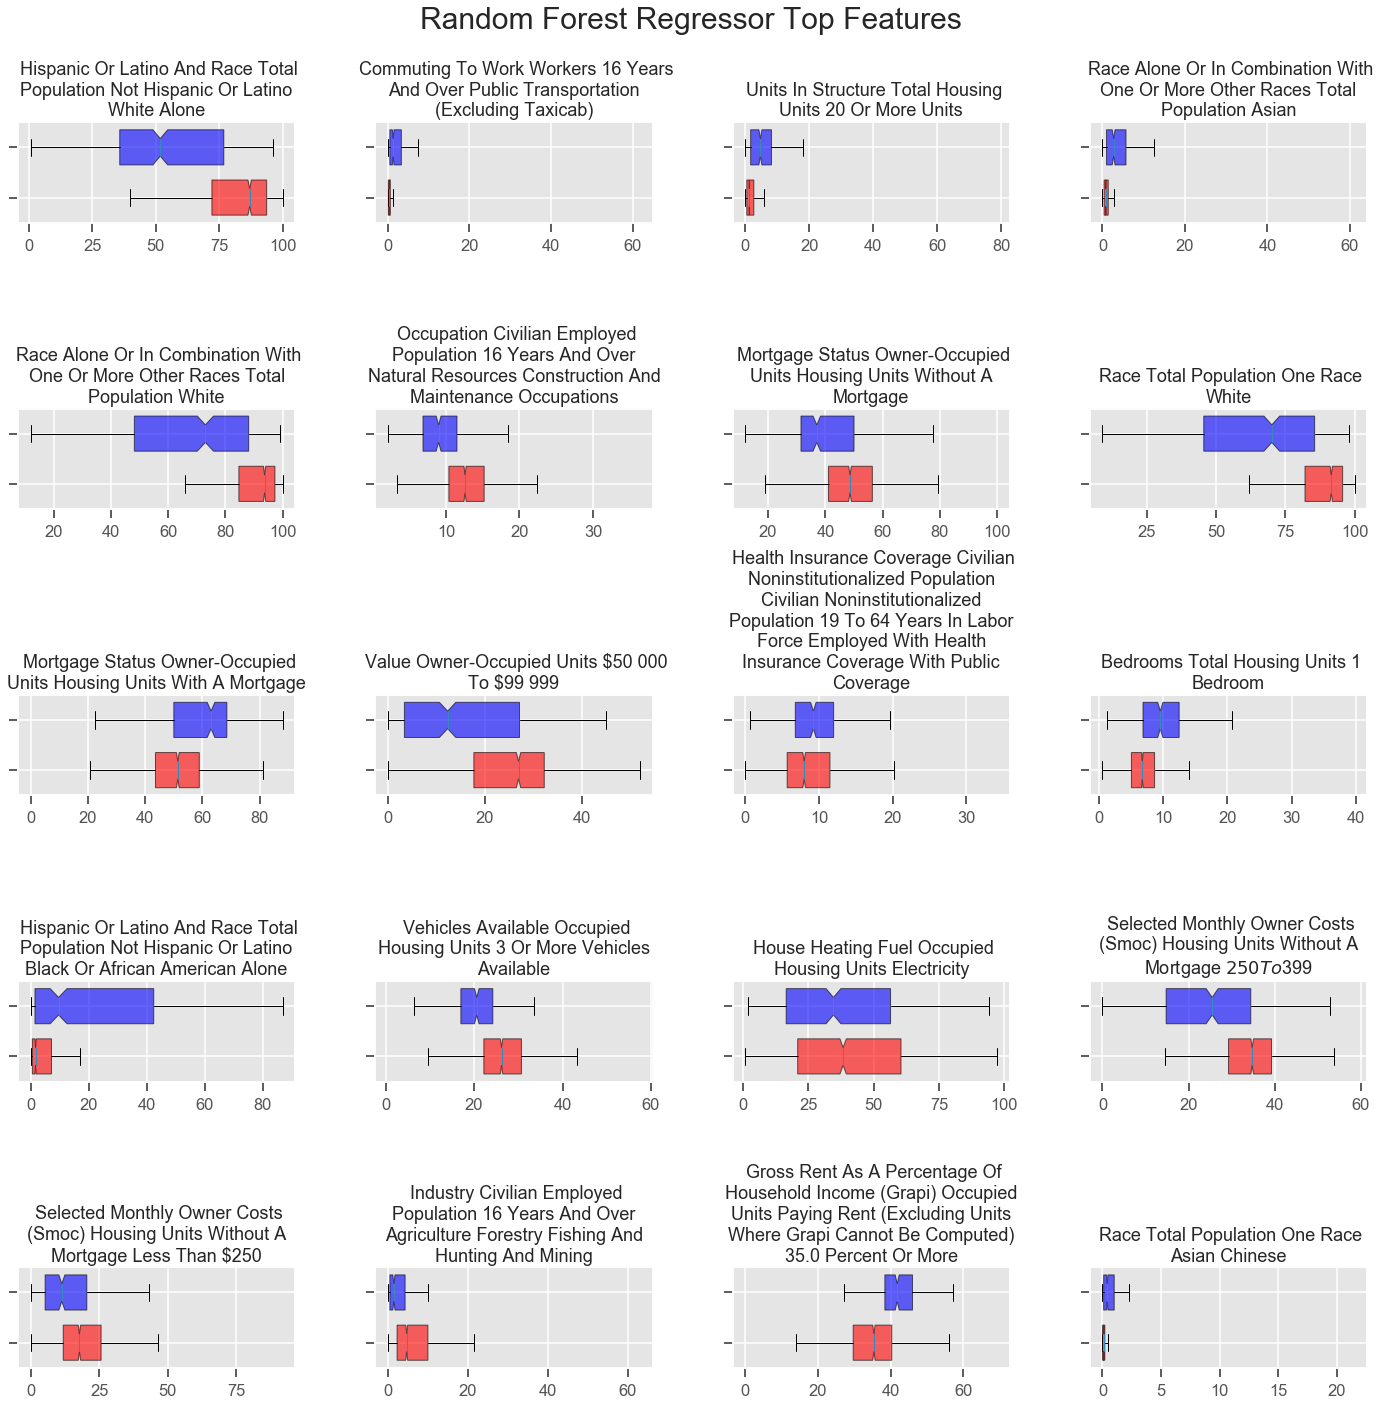

In [535]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
fig.suptitle("Random Forest Regressor Top Features", fontsize=30)
for i in range(20):
    bp = ax[i//4, i%4].boxplot([X.loc[y==1, rfr_features.index[i]], X.loc[y==0, rfr_features.index[i]]],
                               vert=False,
                               labels=["T", "H"],
                               notch=True, 
                               patch_artist=True,
                               widths=0.7
                              )
    for patch, color in zip(bp['boxes'], ["red", "blue"]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

#     ax[i//4, i%4].set_xticklabels([])
    ax[i//4, i%4].set_yticklabels([])
    ax[i//4, i%4].set_title("\n".join(wrap(rfr_features.label[i], 35)),
                            fontsize=18
                           )
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig("images/rfr_features_box")
plt.show()

In [537]:
svr = SVR(kernel="linear")
svr.fit(X_train_scaled, ym_train)
print("train: ", svr.score(X_train_scaled, ym_train))
print("test: ", svr.score(X_test_scaled, ym_test))

train:  0.8712050987403589
test:  0.8413117622771511


In [538]:
svr_features = pd.merge(pd.DataFrame(svr.coef_.T, 
             index=X.iloc[:, 2:].columns, 
             columns=["importance"]
            ).apply(lambda x: np.abs(x)).
                        sort_values(by="importance", ascending=False),
                        var_description, 
                        how="left",
                        right_index=True, left_index=True)

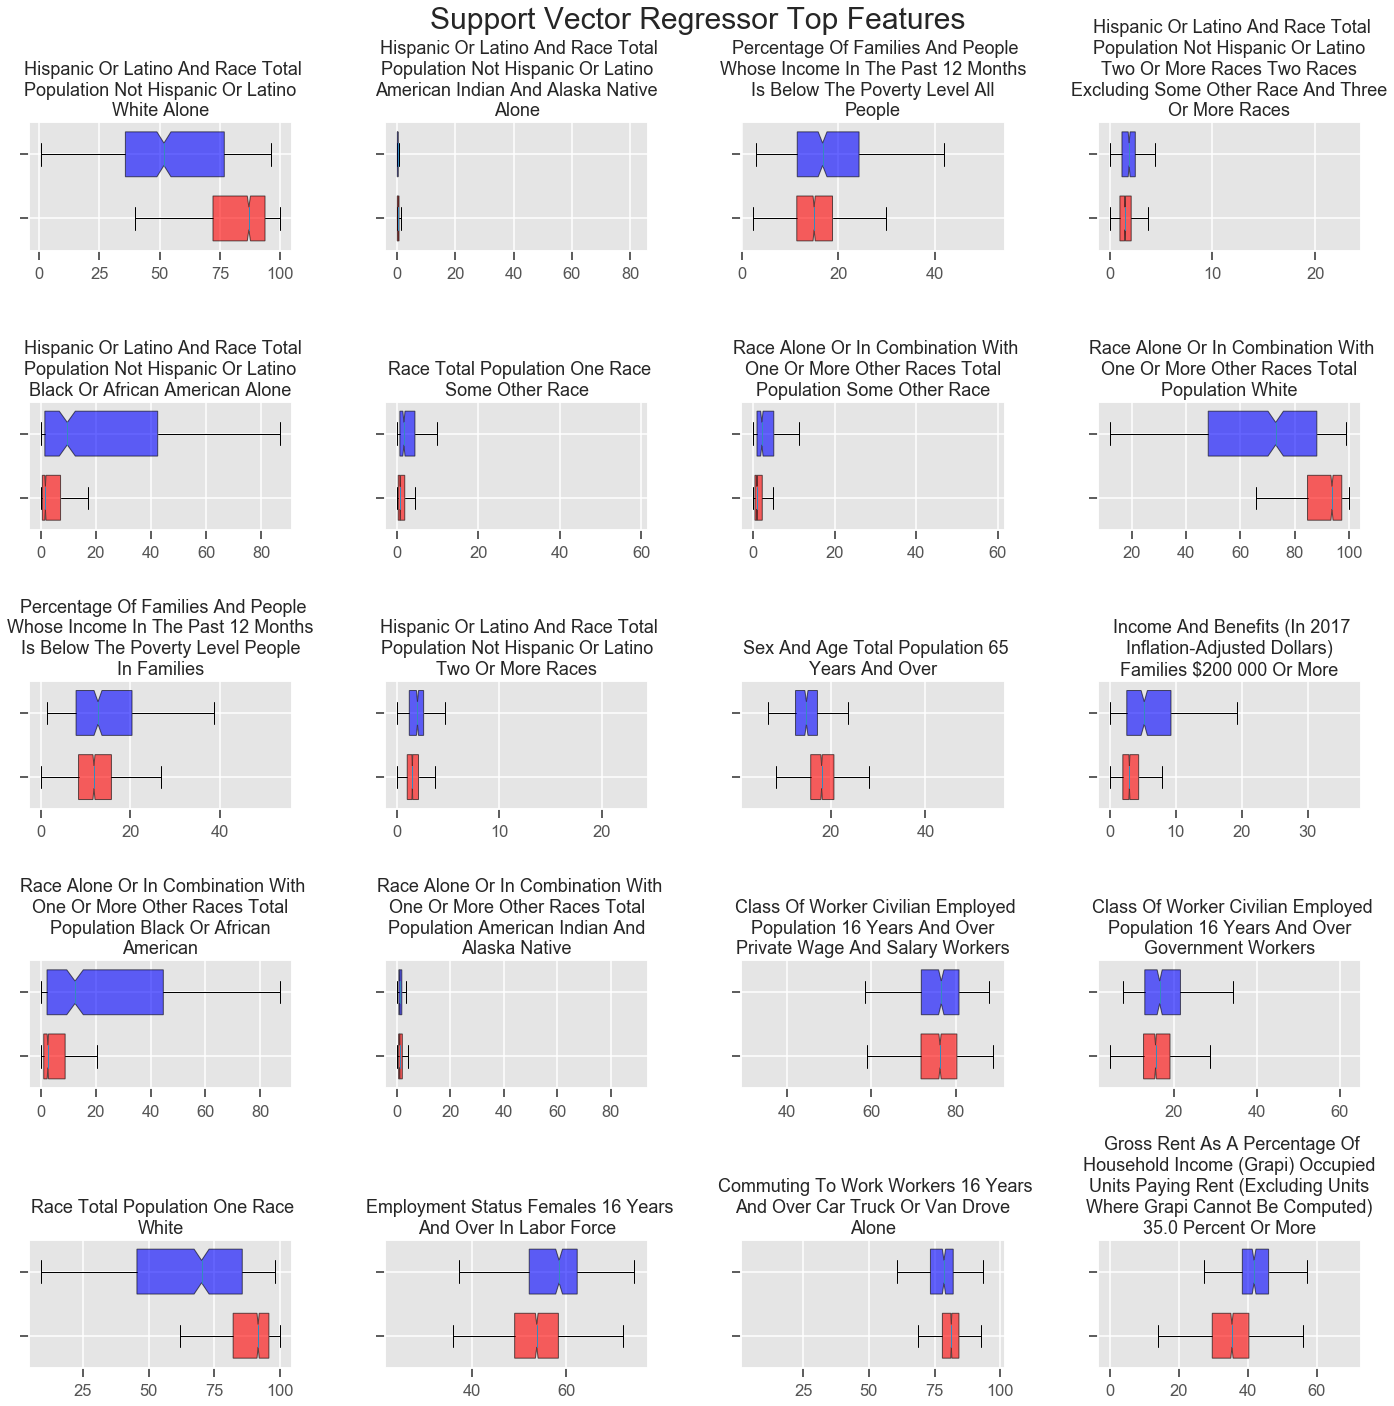

In [539]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
fig.suptitle("Support Vector Regressor Top Features", fontsize=30)
for i in range(20):
    bp = ax[i//4, i%4].boxplot([X.loc[y==1, svr_features.index[i]], X.loc[y==0, svr_features.index[i]]],
                               vert=False,
                               labels=["T", "H"],
                               notch=True, 
                               patch_artist=True,
                               widths=0.7
                              )
    for patch, color in zip(bp['boxes'], ["red", "blue"]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

#     ax[i//4, i%4].set_xticklabels([])
    ax[i//4, i%4].set_yticklabels([])
    ax[i//4, i%4].set_title("\n".join(wrap(svr_features.label[i], 35)),
                            fontsize=18
                           )
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig("images/svr_features_box")
plt.show()

In [544]:
xgr = XGBRegressor()
xgr.fit(X_train_scaled, 
        ym_train,
        eval_set=[(X_train_scaled, ym_train), (X_test_scaled, ym_test)],
        early_stopping_rounds=10,
        verbose=False)
print("train: ", xgr.score(X_train_scaled, ym_train))
print("test: ", xgr.score(X_test_scaled, ym_test))

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train:  0.9284541050741973
test:  0.8619655089289472


In [541]:
xgr_features = pd.merge(pd.DataFrame(xgr.feature_importances_, 
             index=X.iloc[:, 2:].columns, 
             columns=["importance"]
            ).sort_values(by="importance", ascending=False), var_description, how="left",
                        right_index=True, left_index=True)

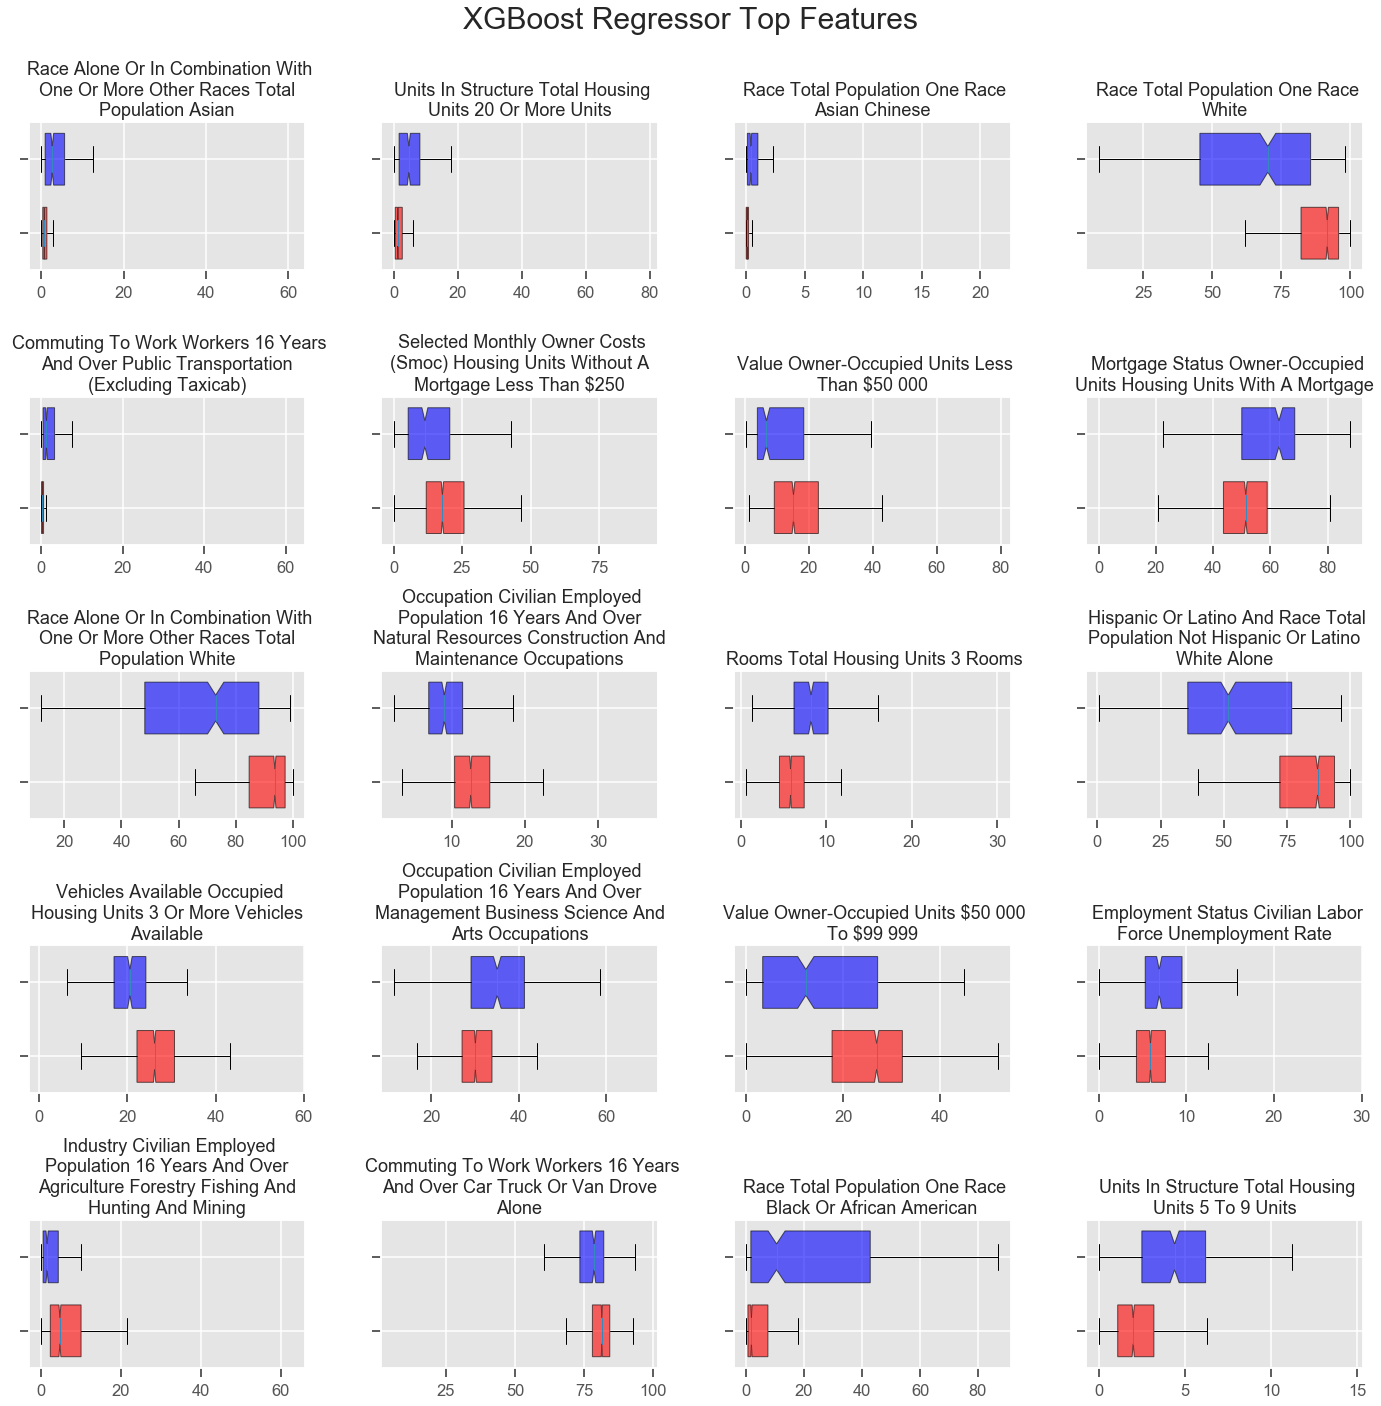

In [542]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
fig.suptitle("XGBoost Regressor Top Features", fontsize=30)
for i in range(20):
    bp = ax[i//4, i%4].boxplot([X.loc[y==1, xgr_features.index[i]], X.loc[y==0, xgr_features.index[i]]],
                               vert=False,
                               labels=["T", "H"],
                               notch=True, 
                               patch_artist=True,
                               widths=0.7
                              )
    for patch, color in zip(bp['boxes'], ["red", "blue"]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

#     ax[i//4, i%4].set_xticklabels([])
    ax[i//4, i%4].set_yticklabels([])
    ax[i//4, i%4].set_title("\n".join(wrap(xgr_features.label[i], 35)),
                            fontsize=18
                           )
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig("images/xgr_features_box")
plt.show()

In [550]:
X_train, X_test, ym_train, ym_test = train_test_split(X, y_margin)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.iloc[:, 2:])
X_test_scaled = scaler.transform(X_test.iloc[:, 2:])
xgr = XGBRegressor(verbose=False)
xgr.fit(X_train_scaled, ym_train)
pred = pd.DataFrame(xgr.predict(X_test_scaled), index=X_test.index)

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:10:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [555]:
xgr_trials = pd.merge(pd.DataFrame(xgr_trials), pred, how="left", left_index=True, right_index=True)

In [562]:
xgr_trials = pd.DataFrame(y_margin, columns=["target"])
for i in range(100):
    X_train, X_test, ym_train, ym_test = train_test_split(X, y_margin)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.iloc[:, 2:])
    X_test_scaled = scaler.transform(X_test.iloc[:, 2:])
    xgr = XGBRegressor(verbose=False)
    xgr.fit(X_train_scaled, ym_train)
    pred = pd.DataFrame(xgr.predict(X_test_scaled), index=X_test.index, columns=[i])

    xgr_trials = pd.merge(xgr_trials, pred, how="left", left_index=True, right_index=True)
    if (i+1)%10==0:
        print("progress: {}% done".format(i+1))

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
progress: 10% done
[15:22:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
progress: 20% done
[15:22:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
progress: 30% done
[15:23:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
progress: 40% done
[15:23:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
progress: 50% done
[15:24:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
progress: 60% done
[15:24:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
progress: 70% done
[15:25:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
progress: 80% done
[15:25:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:25:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:26:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:26:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
progress: 90% done
[15:26:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:26:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:26:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:26:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:26:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:26:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:26:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:26:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:26:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:26:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
progress: 100% done


In [572]:
xgr_trials["avg"] = xgr_trials.iloc[:, 1:101].mean(axis=1)
xgr_trials["diff"] = xgr_trials.target - xgr_trials.avg
xgr_trials["FIPS"] = df.FIPS
xgr_trials["trump"] = df.trump
xgr_trials["hillary"] = df.hillary
xgr_trials["state"] = df.state

In [575]:
xgr_trials["diff"].max(), xgr_trials["diff"].min()

(0.40953634221849766, -0.4939398378803561)

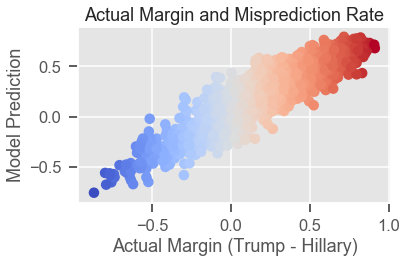

In [576]:
plt.scatter(xgr_trials.target, 
            xgr_trials.avg, 
            c=xgr_trials.target, 
            cmap="coolwarm")
plt.xlabel("Actual Margin (Trump - Hillary)")
plt.ylabel("Model Prediction")
plt.title("Actual Margin and Misprediction Rate")
plt.tight_layout()
plt.savefig("images/xgr_prediction_margin")
plt.show()

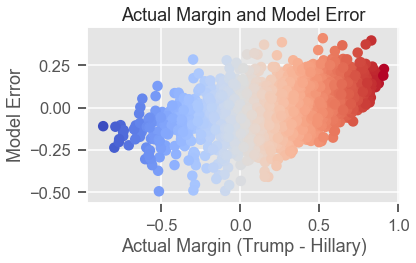

In [578]:
plt.scatter(xgr_trials.target, 
            xgr_trials["diff"], 
            c=xgr_trials.target, 
            cmap="coolwarm")
plt.xlabel("Actual Margin (Trump - Hillary)")
plt.ylabel("Model Error")
plt.title("Actual Margin and Model Error")
plt.tight_layout()
plt.savefig("images/xgr_prediction_error")
plt.show()

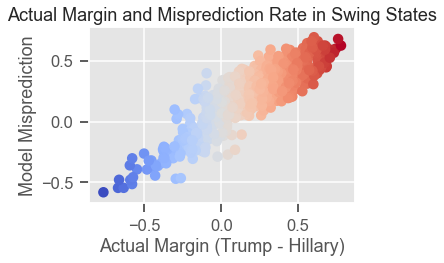

In [577]:
plt.scatter(xgr_trials.loc[(xgc_trials.state.isin(swing_states)), "target"], 
            xgr_trials.loc[(xgc_trials.state.isin(swing_states)), "avg"], 
            c=xgr_trials.loc[(xgc_trials.state.isin(swing_states))].target, 
            cmap="coolwarm")
plt.xlabel("Actual Margin (Trump - Hillary)")
plt.ylabel("Model Misprediction")
plt.title("Actual Margin and Misprediction Rate in Swing States")
plt.tight_layout()
plt.savefig("images/xgr_prediction_margin_swing")
plt.show()